# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1459]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pd.set_option('display.max_columns', None)

# magic word for producing visualizations in notebook
%matplotlib inline
sns.set(style="darkgrid", palette="muted", color_codes=True)

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [827]:
# Load in the general demographics data.
azdias = pd.read_csv('data/Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('data/AZDIAS_Feature_Summary.csv', delimiter=';')

### Dataset Examination

In [828]:
# Examine number of rows and columns
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [829]:
# Examine first few rows
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


### Feature Summary Examination

In [830]:
# Examine number of rows and columns
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.8+ KB


In [831]:
# Examine first few rows
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!



In [832]:
ratio_missing = azdias.isna().mean()
ratio_missing.sort_values(ascending=False).head(20)

KK_KUNDENTYP        0.655967
KBA05_ANTG1         0.149597
KBA05_ANTG2         0.149597
KBA05_ANTG3         0.149597
KBA05_ANTG4         0.149597
KBA05_BAUMAX        0.149597
KBA05_GBZ           0.149597
MOBI_REGIO          0.149597
REGIOTYP            0.135989
KKK                 0.135989
PLZ8_ANTG3          0.130736
PLZ8_ANTG1          0.130736
PLZ8_GBZ            0.130736
PLZ8_ANTG2          0.130736
PLZ8_HHZ            0.130736
PLZ8_BAUMAX         0.130736
PLZ8_ANTG4          0.130736
W_KEIT_KIND_HH      0.120735
KBA13_ANZAHL_PKW    0.118714
CAMEO_INTL_2015     0.111060
dtype: float64

In [833]:
def calc_nan(dataframe):
    """Calculate ratio of NaN values in dataframe"""
    total_nan = dataframe.isna().sum().sum()
    total_cells = np.prod(dataframe.shape)
    ratio = round(total_nan / total_cells * 100, 2)
    return f'Ratio of NaNs in dataframe: {ratio}%'

In [834]:
# Ratio of NaNs in dataframe
print(calc_nan(azdias))

Ratio of NaNs in dataframe: 6.46%


Based on initial exploration, `KK_KUNDENTYP` has the highest ratio of null values at 65.6%.  Additionally, NaNs in the dataframe comprise 6.46% of all values.

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

#### Step 1.1.1 Solution:

In [835]:
# Copy the dataframe
azdias_df = azdias.copy()

In [836]:
# Assess encoding of missing or unknown values
print(feat_info['missing_or_unknown'].unique())

# Examine which attributes have values of X or XX
feat_info.loc[feat_info['missing_or_unknown'].str.contains('X')]

['[-1,0]' '[-1,0,9]' '[0]' '[-1]' '[]' '[-1,9]' '[-1,X]' '[XX]' '[-1,XX]']


,attribute,information_level,type,missing_or_unknown
57,CAMEO_DEUG_2015,microcell_rr4,categorical,"[-1,X]"
58,CAMEO_DEU_2015,microcell_rr4,categorical,[XX]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"


After assessing the missing / unknown codes, most are integers but some attributes' missing / unknown codes are represented in the form of 'X' or 'XX'.  To make the mapping of codes easier, we should map these string representations into an integer.

Examining the data dictionary, it appears that 'X' / 'XX' values are the same as -1, which signify 'unknown'.  Below is an example of `CAMEO_DEUG_2015`:

>4.1. CAMEO_DEUG_2015
>German CAMEO: Wealth / Life Stage Typology, rough scale
>
>- __-1: unknown__
>- 1: upper class
>- 2: upper middleclass
>- 3: established middleclass
>- 4: consumption-oriented middleclass
>- 5: active middleclass
>- 6: low-consumption middleclass
>- 7: lower middleclass
>- 8: working class
>- 9: urban working class
>- __X: unknown__

Therefore, our initial assumption is that we can map 'X' and 'XX' values to the integer equivalent.  The exception to this is __`CAMEO_DEU_2015`__ which contain a mix of integers and letters (e.g. `1A`). Since this column has a mix of integers and letters, even if we convert 'XX' to -1, it will still cause issues down the road due to mixed data types.  

Below are the pre-processing steps for these 3 columns:
1. We will first focus on converting X/XX values in `CAMEO_DEUG_2015` and `CAMEO_INTL_2015` to -1.  
2. Then, we will manually map XX values in `CAMEO_DEU_2015` to a NaN value.  
3. Finally, we will adjust the feature summary dataframe to remove the non-integer value so we can programmatically adjust all the other missing/unknown value encodings for other columns.

In [837]:
# Step 1: Convert X/XX values in 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015' to -1
x_columns = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']

for col in x_columns:
    azdias_df[col] = azdias_df[col].replace({'X': -1,
                                             'XX': -1})
    print(f'Before: \n{azdias[col].value_counts()}')
    print(f'After: \n{azdias_df[col].value_counts()}\n')

Before: 
8    134441
9    108177
6    105874
4    103912
3     86779
2     83231
7     77933
5     55310
1     36212
X       373
Name: CAMEO_DEUG_2015, dtype: int64
After: 
8     134441
9     108177
6     105874
4     103912
3      86779
2      83231
7      77933
5      55310
1      36212
-1       373
Name: CAMEO_DEUG_2015, dtype: int64

Before: 
51    133694
41     92336
24     91158
14     62884
43     56672
54     45391
25     39628
22     33155
23     26750
13     26336
45     26132
55     23955
52     20542
31     19024
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
XX       373
Name: CAMEO_INTL_2015, dtype: int64
After: 
51    133694
41     92336
24     91158
14     62884
43     56672
54     45391
25     39628
22     33155
23     26750
13     26336
45     26132
55     23955
52     20542
31     19024
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
-1       373
Name: CAMEO_INTL_2015, dtype: int64

In [838]:
# Step 2: Manually map XX values in CAMEO_DEU_2015 to NaN
print(f'Before: {azdias_df["CAMEO_DEU_2015"].isna().sum()}')
azdias_df['CAMEO_DEU_2015'] = azdias_df['CAMEO_DEU_2015'].replace({'XX': np.nan})
print(f'After: {azdias_df["CAMEO_DEU_2015"].isna().sum()}')

Before: 98979
After: 99352


Once the values in the dataframe are adjusted, we will need to remove the 'X' and 'XX' values from the feature summary dataframe:

In [839]:
# Step 3: Change 'X' and 'XX' values from the feature summary dataframe

# Copy feature summary
feat_info_cp = feat_info.copy()

# Remove the 'X' value from these two attributes
# Note that the list values in the missing_or_unknown is a string object.
feat_info_cp.loc[feat_info_cp['attribute'] == 'CAMEO_DEUG_2015',
                 'missing_or_unknown'] = '[-1]'
feat_info_cp.loc[feat_info_cp['attribute'] == 'CAMEO_INTL_2015',
                 'missing_or_unknown'] = '[-1]'

# Since we already changed unknown values to NaN for this attribute,
# convert the missing_or_unknown cell to an empty list
feat_info_cp.loc[feat_info_cp['attribute'] == 'CAMEO_DEU_2015',
                 'missing_or_unknown'] = '[]'

In [840]:
# Sanity check results
x_columns = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015']

feat_info_cp.loc[feat_info_cp['attribute'].isin(x_columns)]

,attribute,information_level,type,missing_or_unknown
57,CAMEO_DEUG_2015,microcell_rr4,categorical,[-1]
58,CAMEO_DEU_2015,microcell_rr4,categorical,[]
59,CAMEO_INTL_2015,microcell_rr4,mixed,[-1]


#### Programmatically Converting `missing_or_unknown` values to NaN

The function below converts data that matches a 'missing' or 'unknown' value code into a numpy NaN value.  The subsequent cell calls the function, passing the `azdias` dataframe and the missing/unknown codes in `feat_info`.

In [841]:
def convert_unknown_data_to_nan(dataframe, unknown_data_series):
    """Reads in a dataframe and maps unknown data to NaN values
    Args:
        dataframe - Pandas dataframe
        unknown_data_series - Numpy series of lists that indicate 
            missing or unknown data.
    Returns:
        Dataframe where missing or unknown data is converted to NaN
    """
    for column, row in zip(dataframe, unknown_data_series):
        # Skip over columns where there are no codes for missing/unknown values
        if row != '[]':
            pre_preprocess = dataframe[column].isna().sum()
            # Convert string representation of a list to an actual list
            result = row.strip('][').split(',')
            # Convert string representation of integers to actual integers
            result_int = [int(i) for i in result]
            # Transform column with NaN values in place
            dataframe[column] = dataframe[column].map(
                lambda x: np.nan if x in result_int else x    
            )
            post_preprocess = dataframe[column].isna().sum()
            # Print pre/post-processing NaN counts
            if pre_preprocess != post_preprocess:
                print(column)
                print(f'Pre-preprocess: {pre_preprocess}')
                print(f'Post-preprocess: {post_preprocess}\n')
    return dataframe

In [842]:
# Call the function and copy over to another dataframe
azdias_res = convert_unknown_data_to_nan(azdias_df, feat_info_cp['missing_or_unknown']).copy()

AGER_TYP
Pre-preprocess: 0
Post-preprocess: 685843

ALTERSKATEGORIE_GROB
Pre-preprocess: 0
Post-preprocess: 2881

GEBURTSJAHR
Pre-preprocess: 0
Post-preprocess: 392318

HEALTH_TYP
Pre-preprocess: 0
Post-preprocess: 111196

LP_LEBENSPHASE_FEIN
Pre-preprocess: 4854
Post-preprocess: 97632

LP_LEBENSPHASE_GROB
Pre-preprocess: 4854
Post-preprocess: 94572

LP_FAMILIE_FEIN
Pre-preprocess: 4854
Post-preprocess: 77792

LP_FAMILIE_GROB
Pre-preprocess: 4854
Post-preprocess: 77792

NATIONALITAET_KZ
Pre-preprocess: 0
Post-preprocess: 108315

PRAEGENDE_JUGENDJAHRE
Pre-preprocess: 0
Post-preprocess: 108164

SHOPPER_TYP
Pre-preprocess: 0
Post-preprocess: 111196

TITEL_KZ
Pre-preprocess: 73499
Post-preprocess: 889061

VERS_TYP
Pre-preprocess: 0
Post-preprocess: 111196

ALTER_HH
Pre-preprocess: 73499
Post-preprocess: 310267

W_KEIT_KIND_HH
Pre-preprocess: 107602
Post-preprocess: 147988

ANZ_HAUSHALTE_AKTIV
Pre-preprocess: 93148
Post-preprocess: 99611

CAMEO_DEUG_2015
Pre-preprocess: 98979
Post-preproces

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

#### Step 1.1.2 Solution:

The first step in assessing how much data is missing is by summing the number of NaN values in each column.  Value counts are then sorted in order of highest numbers, and also plotted in a histogram.

In [843]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
ratio_missing = azdias_res.isna().mean()
ratio_missing.sort_values(ascending=False).head(20)

TITEL_KZ          0.997576
AGER_TYP          0.769554
KK_KUNDENTYP      0.655967
KBA05_BAUMAX      0.534687
GEBURTSJAHR       0.440203
ALTER_HH          0.348137
REGIOTYP          0.177357
KKK               0.177357
W_KEIT_KIND_HH    0.166051
KBA05_ANTG4       0.149597
KBA05_GBZ         0.149597
MOBI_REGIO        0.149597
KBA05_ANTG1       0.149597
KBA05_ANTG2       0.149597
KBA05_ANTG3       0.149597
PLZ8_GBZ          0.130736
PLZ8_HHZ          0.130736
PLZ8_BAUMAX       0.130736
PLZ8_ANTG4        0.130736
PLZ8_ANTG1        0.130736
dtype: float64

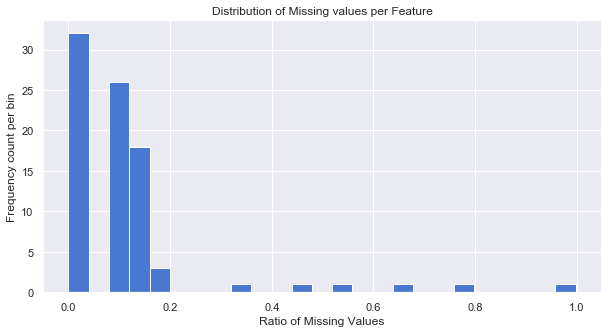

In [844]:
# Plot data to a histogram
plt.figure(figsize=(10,5))
plt.hist(ratio_missing, bins=25)
plt.xlabel('Ratio of Missing Values')
plt.ylabel('Frequency count per bin')
plt.title('Distribution of Missing values per Feature');

We can merge the result to the feature summary dataframe

In [845]:
# Convert NaN ratio to dataframe
rm_df = ratio_missing.rename_axis('attribute').reset_index(name='nan_ratio')

# ...and merge to feature summary dataframe
fi_merged = pd.merge(left=feat_info_cp, right=rm_df, on='attribute')

fi_merged

,attribute,information_level,type,missing_or_unknown,nan_ratio
0,AGER_TYP,person,categorical,"[-1,0]",0.769554
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]",0.003233
2,ANREDE_KZ,person,categorical,"[-1,0]",0.000000
3,CJT_GESAMTTYP,person,categorical,[0],0.005446
4,FINANZ_MINIMALIST,person,ordinal,[-1],0.000000
...,...,...,...,...,...
80,PLZ8_HHZ,macrocell_plz8,ordinal,[-1],0.130736
81,PLZ8_GBZ,macrocell_plz8,ordinal,[-1],0.130736
82,ARBEIT,community,ordinal,"[-1,9]",0.109260
83,ORTSGR_KLS9,community,ordinal,"[-1,0]",0.109147


In [846]:
# Examine average nan_ratio by information_level
fi_merged.groupby('information_level').mean()

,nan_ratio
information_level,
building,0.103098
community,0.109222
household,0.205450
macrocell_plz8,0.129234
microcell_rr3,0.213779
microcell_rr4,0.111479
person,0.077389
postcode,0.105182
region_rr1,0.122856


Calculate how many total missing values there are after converting missing_or_unknown values:

In [847]:
print(f'Before: {calc_nan(azdias)}')
print(f'After: {calc_nan(azdias_res)}')

Before: Ratio of NaNs in dataframe: 6.46%
After: Ratio of NaNs in dataframe: 11.05%


Deep dive into high NaN value features with similar metadata

In [848]:
fi_merged.loc[fi_merged['attribute'].str.contains('KBA05')]

,attribute,information_level,type,missing_or_unknown,nan_ratio
60,KBA05_ANTG1,microcell_rr3,ordinal,[-1],0.149597
61,KBA05_ANTG2,microcell_rr3,ordinal,[-1],0.149597
62,KBA05_ANTG3,microcell_rr3,ordinal,[-1],0.149597
63,KBA05_ANTG4,microcell_rr3,ordinal,[-1],0.149597
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]",0.534687
65,KBA05_GBZ,microcell_rr3,ordinal,"[-1,0]",0.149597


In [849]:
fi_merged.loc[fi_merged['attribute'].str.contains('PLZ8')]

,attribute,information_level,type,missing_or_unknown,nan_ratio
75,PLZ8_ANTG1,macrocell_plz8,ordinal,[-1],0.130736
76,PLZ8_ANTG2,macrocell_plz8,ordinal,[-1],0.130736
77,PLZ8_ANTG3,macrocell_plz8,ordinal,[-1],0.130736
78,PLZ8_ANTG4,macrocell_plz8,ordinal,[-1],0.130736
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]",0.130736
80,PLZ8_HHZ,macrocell_plz8,ordinal,[-1],0.130736
81,PLZ8_GBZ,macrocell_plz8,ordinal,[-1],0.130736


Find the columns with the highest ratio of NaN values, and remove from dataframe

In [850]:
# Find columns where the NaN values are in the 75th percentile
print(ratio_missing.describe())

nan_75 = np.where(azdias_res.isna().mean() >= 0.130736)
azdias_res.columns[nan_75]

count    85.000000
mean      0.110541
std       0.164498
min       0.000000
25%       0.000000
50%       0.104517
75%       0.130736
max       0.997576
dtype: float64


Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'W_KEIT_KIND_HH', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3',
       'KBA05_ANTG4', 'KBA05_BAUMAX', 'KBA05_GBZ', 'KKK', 'MOBI_REGIO',
       'REGIOTYP', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4',
       'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ'],
      dtype='object')

In [851]:
# Remove columns where the NaN values are in the 75th percentile
azdias_res.drop(azdias_res.columns[nan_75], axis=1, inplace=True)

# Check results
azdias_res.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO_DEU_2015', 'CAMEO

In [852]:
nan_75

(array([ 0, 11, 40, 43, 47, 48, 60, 61, 62, 63, 64, 65, 70, 71, 73, 75, 76,
        77, 78, 79, 80, 81]),)

In [853]:
drop_cols = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'W_KEIT_KIND_HH', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3',
       'KBA05_ANTG4', 'KBA05_BAUMAX', 'KBA05_GBZ', 'KKK', 'MOBI_REGIO',
       'REGIOTYP', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4',
       'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ']
drop_index = feat_info_cp.loc[feat_info_cp['attribute'].isin(drop_cols)].index
fi_drop_na = feat_info_cp.drop(drop_index, axis=0)
fi_drop_na

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
...,...,...,...,...
72,ONLINE_AFFINITAET,region_rr1,ordinal,[]
74,KBA13_ANZAHL_PKW,macrocell_plz8,numeric,[]
82,ARBEIT,community,ordinal,"[-1,9]"
83,ORTSGR_KLS9,community,ordinal,"[-1,0]"


#### Discussion 1.1.2: Assess Missing Data in Each Column

Based on the analysis above, there appear to be 6 notable outliers with a high ratio of `NaN` values.

| Column | Description | Ratio of Missing Values |
| :--- | :--- | ---: |
| `TITEL_KZ`        |  Academic title flag |     0.997576 |
| `AGER_TYP`        |  Best-ager typology |     0.769554 |
| `KK_KUNDENTYP`      |  Consumer pattern over past 12 months |     0.655967 |
| `KBA05_BAUMAX`      |  Most common building type within the microcell |     0.655967 |
| `GEBURTSJAHR`       |  Year of birth |     0.440203 |
| `ALTER_HH`       |  Birthdate of head of household |     0.348137 |

Additionally, there are other columns which share the same number of `NaN` which indicate a pattern:

1. `KBA05` fields, which are derived from the RR3 micro-cell features.  Most features in this group shared a NaN ratio of ~15%, with the exception of `KBA05_BAUMAX` which had a high NaN ratio of 53%.
2. `PLZ8` fields, which are derived from the PLZ8 macro-cell features.  All features in this group shared a NaN ratio of 13%.

Grouping the NaN ratios by the `information_level` column in the feature summary showed that `household` and `microcell_rr3` had the highest average ratio of missing values, both hovering around 20%.  Conversely, the `person` group had the lowest average ratio of missing values at 7.7%.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [854]:
# Count much data is missing in each row of the dataset, then describe the result.
# azdias_na = azdias_res.isna().sum(axis=1)
azdias_na = azdias_res.isna().mean(axis=1)
azdias_na.describe()

count    891221.000000
mean          0.052641
std           0.134214
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           0.523810
dtype: float64

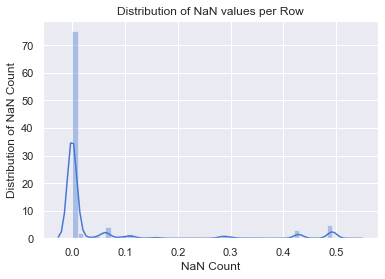

In [855]:
# Plot the distribution
sns.distplot(azdias_na)
plt.xlabel('NaN Count')
plt.ylabel('Distribution of NaN Count')
plt.title('Distribution of NaN values per Row');

In [856]:
# Divide the data into two subsets based on the number of missing
# values in each row.

# Add sum of NaN values as an extra column
azdias_res['nan_count'] = azdias_na

# Divide data into two subsets based on the mean.
# Copy them into new dataframes.
azdias_low = azdias_res.loc[azdias_res['nan_count'] <= .1].copy()
azdias_high = azdias_res.loc[azdias_res['nan_count'] > .1].copy()

In [857]:
# Drop NaN column
azdias_low.drop('nan_count', axis=1, inplace=True)

In [858]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Identify columns where there are no or few missing values
missing_data.sort_values()[:25]

ZABEOTYP                    0
SEMIO_TRADV                 0
SEMIO_PFLICHT               0
SEMIO_KAEM                  0
SEMIO_DOM                   0
SEMIO_KRIT                  0
SEMIO_RAT                   0
SEMIO_KULT                  0
SEMIO_ERL                   0
SEMIO_LUST                  0
SEMIO_VERT                  0
SEMIO_MAT                   0
SEMIO_REL                   0
SEMIO_SOZ                   0
SEMIO_FAM                   0
FINANZ_VORSORGER            0
ANREDE_KZ                   0
FINANZ_MINIMALIST           0
FINANZ_SPARER               0
FINANZ_ANLEGER              0
FINANZ_UNAUFFAELLIGER       0
FINANZ_HAUSBAUER            0
GREEN_AVANTGARDE            0
FINANZTYP                   0
ALTERSKATEGORIE_GROB     2881
dtype: int64

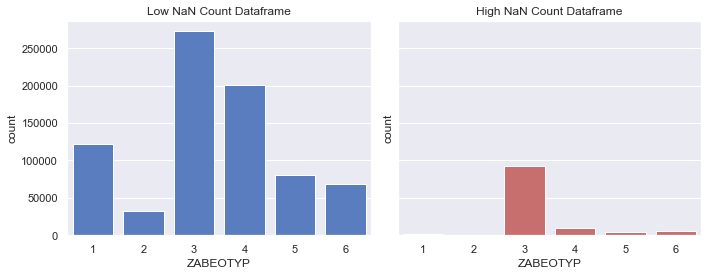

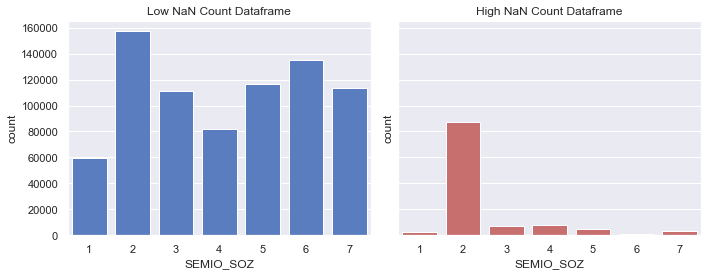

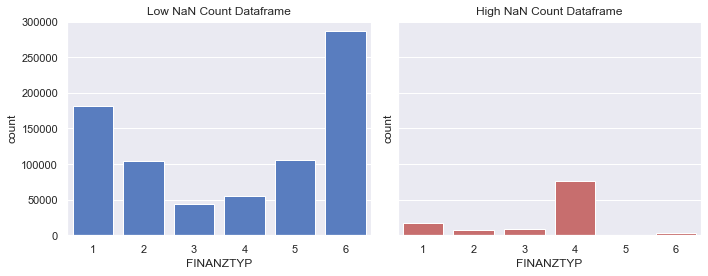

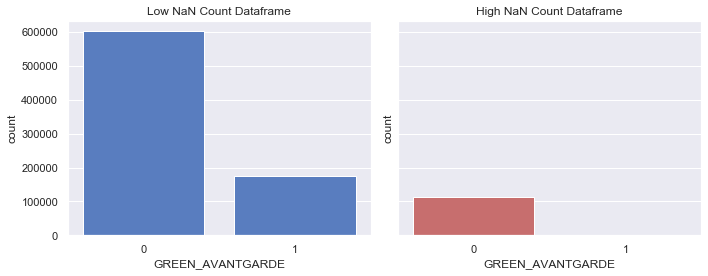

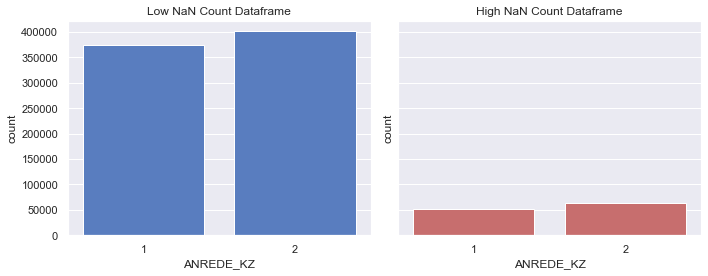

In [859]:
# Plot the distribution and compare results

# Extract five columns from the choices listed above
cols = ['ZABEOTYP', 'SEMIO_SOZ', 'FINANZTYP', 'GREEN_AVANTGARDE', 'ANREDE_KZ']

# Loop through each column and plot distributions
for col in cols:
    # Set up plot attributes
    f, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
    # Plot count plots
    sns.countplot(azdias_low[col], color='b', ax=axes[0])
    sns.countplot(azdias_high[col], color='r', ax=axes[1])
    axes[0].set_title('Low NaN Count Dataframe')
    axes[1].set_title('High NaN Count Dataframe')
    plt.tight_layout();

#### Discussion 1.1.3: Assess Missing Data in Each Row

Plotting the distribution of missing data per row showed a distribution that skewed right with a few outliers.  The outliers showed that there were rows that had up to 40-50% `NaN` cells.  Additionally, the average number of `NaN` values per row was __5%__.  The mean  used as the cut-off point to divide the dataframe to 2 subsets: One with a low number of `NaN` cells (`azdias_low`) and another with a high number of `NaN` (`azdias_high`).  These 2 groups were then plotted with a sample of columns to compare the distribution of values.

The comparative plots showed that while some columns shared a relatively similar distribution (e.g. `ZABEOTYP`, `GREEN_AVANTGARDE`, `ANREDE_KZ`) with account to difference in scale, others (e.g. `SEMIO_SOZ`, `FINANZTYP`) showed noticeably different distribution characteristics.  Consequently, further analysis using the subset of data with low number of `NaN` cells for certain columns like those mentioned above should be interpreted with some caution.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [865]:
# How many features are there of each data type?
fi_drop_na['type'].value_counts()

ordinal        34
categorical    18
numeric         6
mixed           5
Name: type, dtype: int64

In [867]:
# Examine categorical features
feat_cat = fi_drop_na.loc[fi_drop_na['type'] == 'categorical']
feat_cat

,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]
21,NATIONALITAET_KZ,person,categorical,"[-1,0]"


In [869]:
# Count information-levels
feat_cat['information_level'].value_counts()

person           14
building          2
microcell_rr4     2
Name: information_level, dtype: int64

In [870]:
# Get categorical column names
cat_cols = feat_cat.loc[feat_cat['type'] == 'categorical']['attribute']
cat_cols

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [871]:
# Get datatypes of categorical features
azdias_low[cat_cols].dtypes

ANREDE_KZ             int64
CJT_GESAMTTYP       float64
FINANZTYP             int64
GFK_URLAUBERTYP     float64
GREEN_AVANTGARDE      int64
LP_FAMILIE_FEIN     float64
LP_FAMILIE_GROB     float64
LP_STATUS_FEIN      float64
LP_STATUS_GROB      float64
NATIONALITAET_KZ    float64
SHOPPER_TYP         float64
SOHO_KZ             float64
VERS_TYP            float64
ZABEOTYP              int64
GEBAEUDETYP         float64
OST_WEST_KZ          object
CAMEO_DEUG_2015      object
CAMEO_DEU_2015       object
dtype: object

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [873]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

binary = []
categorical = []

for att in feat_cat['attribute']:
    # Prevent errors thrown for dropped columns
    if att in azdias_low.columns:
        # Append features with binary values
        if len(azdias_low[att].value_counts()) <= 2:
            binary.append(att)
        # Append features with multilevel
        else:
            categorical.append(att)
        # Print head values in each column
        print(azdias_low[att].value_counts().head(), '\n')

2    401600
1    374813
Name: ANREDE_KZ, dtype: int64 

4.0    196838
3.0    146492
2.0    140528
5.0    100938
6.0     98664
Name: CJT_GESAMTTYP, dtype: int64 

6    286750
1    181786
5    105336
2    103752
4     54493
Name: FINANZTYP, dtype: int64 

12.0    125961
10.0    100384
8.0      81945
11.0     73716
5.0      69681
Name: GFK_URLAUBERTYP, dtype: int64 

0    602731
1    173682
Name: GREEN_AVANTGARDE, dtype: int64 

1.0     390882
10.0    126364
2.0      98302
11.0     48304
8.0      21778
Name: LP_FAMILIE_FEIN, dtype: int64 

1.0    390882
5.0    185078
2.0     98302
4.0     49867
3.0     27419
Name: LP_FAMILIE_GROB, dtype: int64 

1.0     206486
9.0     136005
10.0    111458
2.0      99176
4.0      72559
Name: LP_STATUS_FEIN, dtype: int64 

1.0    305662
2.0    166962
4.0    154584
5.0    111458
3.0     37747
Name: LP_STATUS_GROB, dtype: int64 

1.0    663379
2.0     63240
3.0     32357
Name: NATIONALITAET_KZ, dtype: int64 

1.0    245866
2.0    204679
3.0    179542
0.0    

In [874]:
# Columns with binary values
print(f'Features with binary values: \n{binary}')
print(f'Total count of binary features: {len(binary)}\n')

# Columns with categorical values
print(f'Features with multilevel values: \n{categorical}')
print(f'Total count of  multilevel features: {len(categorical)}\n')

# OST_WEST_KZ is the unique column where the values are binary but values are strings
print(f'OST_WEST_KZ: Building location via former East / West Germany (GDR / FRG)',
      f'\n{azdias_low["OST_WEST_KZ"].value_counts()}')

Features with binary values: 
['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
Total count of binary features: 5

Features with multilevel values: 
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
Total count of  multilevel features: 13

OST_WEST_KZ: Building location via former East / West Germany (GDR / FRG) 
W    610801
O    165612
Name: OST_WEST_KZ, dtype: int64


In [875]:
# Map OST_WEST_KZ values to binary integers
azdias_low['OST_WEST_KZ'] = azdias_low['OST_WEST_KZ'].replace({'W': 1, 'O': 0})

# Check result
azdias_low['OST_WEST_KZ'].value_counts()

1    610801
0    165612
Name: OST_WEST_KZ, dtype: int64

In [876]:
# Examine multilevel categorical features
azdias_low[categorical].nunique()

CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB      5
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     3
SHOPPER_TYP          4
ZABEOTYP             6
GEBAEUDETYP          7
CAMEO_DEUG_2015      9
CAMEO_DEU_2015      44
dtype: int64

In [877]:
# Drop multilevel categorical features
azdias_drop_cat = azdias_low.drop(categorical, axis=1)

In [878]:
print(f'Columns post filtering categorical features: \n{azdias_drop_cat.columns}\n')
print(f'Number of columns before: {len(azdias_low.columns)}')
print(f'Number of columns after:  {len(azdias_drop_cat.columns)}')

Columns post filtering categorical features: 
Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM',
       'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL',
       'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
       'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_INTL_2015',
       'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER',
       'ONLINE_AFFINITAET', 'KBA13_ANZAHL_PKW', 'ARBEIT', 'ORTSGR_KLS9',
       'RELAT_AB'],
      dtype='object')

Number o

# Discussion 1.2.1: Re-Encode Categorical Features

In the dataset, we found a total of 18 categorical features.  Of those features:
1. 14 were in the person group
2. 2 were in the building group
3. 2 were int he microcell_rr4 group

Amongst these features, there were 5 features with binary values and 18 features with multilevel values.

```
Features with binary values: 
['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
Total count of binary features: 5

Features with multilevel values: 
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
Total count of  multilevel features: 13
```

There was one unique feature, `OST_WEST_KZ`, which contained binary values but saved as a string rather than an integer.  In this case, we replaced the strings with integers so it can be used with the clustering algorithms.

I've decided to drop the features with multilevel values due to time constrains and the fact that some of these features like `LP_LEBENSPHASE_FEIN` contain multivariate variables within it (e.g. "single low-income earners of younger age") that may already be accounted for in other features.

In conclusion, after the re-encoding step, we've filtered down from a total number of 63 columns down to 50 columns - accounting for a total of 13 features being removed.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

##### "PRAEGENDE_JUGENDJAHRE"

In [881]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_drop_cat['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    181730
8.0     140583
10.0     85163
5.0      84023
3.0      53391
15.0     42200
11.0     35425
9.0      33270
6.0      25412
12.0     24326
1.0      20384
4.0      20280
2.0       7404
13.0      5712
7.0       3979
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [891]:
pj_vc = azdias_drop_cat['PRAEGENDE_JUGENDJAHRE'].value_counts()
pj_sum = azdias_drop_cat['PRAEGENDE_JUGENDJAHRE'].sum()
round(pj_vc / pj_sum, 2)

14.0    0.03
8.0     0.02
10.0    0.01
5.0     0.01
3.0     0.01
15.0    0.01
11.0    0.00
9.0     0.00
6.0     0.00
12.0    0.00
1.0     0.00
4.0     0.00
2.0     0.00
13.0    0.00
7.0     0.00
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In order to understand how to map the values, `Data_Dictionary.md` explains the decades and movements each integer signifies:

>Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
>```
-1: unknown
0: unknown
1: 40s - war years (Mainstream, E+W)
2: 40s - reconstruction years (Avantgarde, E+W)
3: 50s - economic miracle (Mainstream, E+W)
4: 50s - milk bar / Individualisation (Avantgarde, E+W)
5: 60s - economic miracle (Mainstream, E+W)
6: 60s - generation 68 / student protestors (Avantgarde, W)
7: 60s - opponents to the building of the Wall (Avantgarde, E)
8: 70s - family orientation (Mainstream, E+W)
9: 70s - peace movement (Avantgarde, E+W)
10: 80s - Generation Golf (Mainstream, W)
11: 80s - ecological awareness (Avantgarde, W)
12: 80s - FDJ / communist party youth organisation (Mainstream, E)
13: 80s - Swords into ploughshares (Avantgarde, E)
14: 90s - digital media kids (Mainstream, E+W)
15: 90s - ecological awareness (Avantgarde, E+W)
>```

This will require some manual mapping of decades/movements to groupings.  The idea will be that each grouping of a feature will be mapped to an ordinal like below:

```
decade_40 = [1,2]
decade_50 = [3,4]
decade_60 = [5,6,7]
decade_70 = [8,9]
decade_80 = [10,11,12,13]
decade_90 = [14,15]

mainstream = [1,3,5,8,10,12,14]
avantgarde = [2,4,6,7,9,11,13,15]
```

These mappings will be added to new features:

- `decade` - Decade the person spent their youth
- `movement` - Political alignment of the person during their youth

In [882]:
# Manually map each variables to a new integer
decades = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 
           9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
movement = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 
            9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}

# Apply the mapping
azdias_drop_cat['decade'] = azdias_drop_cat['PRAEGENDE_JUGENDJAHRE'].map(decades)
azdias_drop_cat['movement'] = azdias_drop_cat['PRAEGENDE_JUGENDJAHRE'].map(movement)

azdias_drop_cat[['PRAEGENDE_JUGENDJAHRE','decade','movement']].sample(10)

,PRAEGENDE_JUGENDJAHRE,decade,movement
867383,12.0,5.0,0.0
75094,14.0,6.0,0.0
642657,NaN,NaN,NaN
584375,8.0,4.0,0.0
131810,3.0,2.0,0.0
511163,8.0,4.0,0.0
185058,14.0,6.0,0.0
46373,10.0,5.0,0.0
750447,9.0,4.0,1.0
379821,4.0,2.0,1.0


In [907]:
# Get raw counts
azdias_drop_cat['decade'].value_counts()

6.0    223930
4.0    173853
5.0    150626
3.0    113414
2.0     73671
1.0     27788
Name: decade, dtype: int64

In [924]:
# Get ratios
azdias_drop_cat['decade'].value_counts() / azdias_drop_cat['decade'].count() * 100

6.0    29.337781
4.0    22.777034
5.0    19.733991
3.0    14.858728
2.0     9.651872
1.0     3.640594
Name: decade, dtype: float64

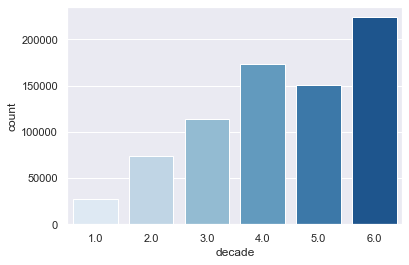

In [905]:
# Plot distribution of decade feature
sns.countplot(azdias_drop_cat['decade'], palette='Blues');

In [946]:
# Assess ratio of missing values
azdias_drop_cat['decade'].isna().sum() / \
    azdias_drop_cat['decade'].count() * 100

1.7203340311968578

In [916]:
# Get raw counts
azdias_drop_cat['movement'].value_counts()

0.0    589600
1.0    173682
Name: movement, dtype: int64

In [925]:
# Get ratios
azdias_drop_cat['movement'].value_counts() / azdias_drop_cat['movement'].count()* 100

0.0    77.245369
1.0    22.754631
Name: movement, dtype: float64

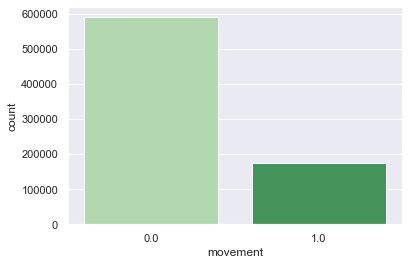

In [906]:
# Plot distribution of movement feature
sns.countplot(azdias_drop_cat['movement'], palette='Greens');

In [947]:
# Assess ratio of missing values
azdias_drop_cat['movement'].isna().sum() / \
    azdias_drop_cat['movement'].count() * 100

1.7203340311968578

The breakdown of the PRAEGENDE_JUGENDJAHRE feature into decade and movement reveal the following:

1. The number of persons who spent their youth in the 90s accounts for the highest count (29% of total), followed by the 70s (22%).  The least represented were those who spent their youth in the 40s and 50s (9.6% and 3.7% respectively).
2. The number of persons whose political alignment during their youth was with the mainstream far surpassed those who alinged themselves with the avant-garde (77.2% vs 22.7%)
3. Both features had a relatively small ratio of missing values at around 1.6% average.

##### "CAMEO_INTL_2015"

In [931]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_drop_cat['CAMEO_INTL_2015'].value_counts()

51    128584
41     89516
24     89175
14     61638
43     55184
54     44137
25     38865
22     32465
23     26209
13     25817
45     25601
55     23409
52     19656
31     18502
34     17969
15     16685
44     14429
12     12998
35     10118
32     10108
33      9711
Name: CAMEO_INTL_2015, dtype: int64

In [936]:
# Calculate ratios
azdias_drop_cat['CAMEO_INTL_2015'].value_counts() / \
    azdias_drop_cat['CAMEO_INTL_2015'].count() * 100

51    16.682408
41    11.613750
24    11.569509
14     7.996876
43     7.159538
54     5.726307
25     5.042321
22     4.211989
23     3.400339
13     3.349482
45     3.321458
55     3.037069
52     2.550157
31     2.400438
34     2.331287
15     2.164702
44     1.872010
12     1.686352
35     1.312703
32     1.311406
33     1.259899
Name: CAMEO_INTL_2015, dtype: float64

In [944]:
# Assess ratio of missing values
azdias_drop_cat['CAMEO_INTL_2015'].isna().sum() / \
    azdias_drop_cat['CAMEO_INTL_2015'].count() * 100

0.7313408824353639

Below is how the numbers are mapped to values in `CAMEO_INTL_2015`:

> German CAMEO: Wealth / Life Stage Typology, mapped to international code
> 
> - -1: unknown
> - 11: Wealthy Households - Pre-Family Couples & Singles
> - 12: Wealthy Households - Young Couples With Children
> - 13: Wealthy Households - Families With School Age Children
> - 14: Wealthy Households - Older Families & Mature Couples
> - 15: Wealthy Households - Elders In Retirement
> - 21: Prosperous Households - Pre-Family Couples & Singles
> - 22: Prosperous Households - Young Couples With Children
> - 23: Prosperous Households - Families With School Age Children
> - 24: Prosperous Households - Older Families & Mature Couples
> - 25: Prosperous Households - Elders In Retirement
> - 31: Comfortable Households - Pre-Family Couples & Singles
> - 32: Comfortable Households - Young Couples With Children
> - 33: Comfortable Households - Families With School Age Children
> - 34: Comfortable Households - Older Families & Mature Couples
> - 35: Comfortable Households - Elders In Retirement
> - 41: Less Affluent Households - Pre-Family Couples & Singles
> - 42: Less Affluent Households - Young Couples With Children
> - 43: Less Affluent Households - Families With School Age Children
> - 44: Less Affluent Households - Older Families & Mature Couples
> - 45: Less Affluent Households - Elders In Retirement
> - 51: Poorer Households - Pre-Family Couples & Singles
> - 52: Poorer Households - Young Couples With Children
> - 53: Poorer Households - Families With School Age Children
> - 54: Poorer Households - Older Families & Mature Couples
> - 55: Poorer Households - Elders In Retirement
> - XX: unknown

We can map this into 2 features with each integer representing the ordered lists:

- `wealth`: The wealth stage of the household
    1. Wealthy
    2. Propserous
    3. Comfortable
    4. Less Affluent
    5. Poorer
    
- `life_stage`: The life stage of the household
    1. Pre-Family Couples & Singles
    2. Young Couples With Children
    3. Families With School Age Children
    4. Older Families & Mature Couples
    5. Elders In Retirement

We will map the first integer (ie. values in multiple of tens) to the `wealth` feature, and the second integer to the `life_stage` feature.

In [965]:
def split_digits(series):
    """Takes in a numpy series and splits two-digit numbers by their
    first integer and second integer (e.g. 10 => 1 and 0), and appends
    each to separate lists
    
    Args:
        series - numpy series
    Returns:
        tens - list of the first integer extracted from numpy series
        ones - list of the second integer extracted from numpy series
    """
    tens = []
    ones = []
    for row in series:
        if not pd.isna(row):
            tens.append(int(str(row)[0]))
            ones.append(int(str(row)[1]))
        # Make sure to append NaN values, otherwise the index
        # will not match
        else:
            tens.append(None)
            ones.append(None)
    return tens, ones

In [958]:
# Split up data, assign to two variables
tens, ones = split_digits(azdias_drop_cat['CAMEO_INTL_2015'])

In [959]:
# Assign to new features
azdias_drop_cat['wealth'] = tens
azdias_drop_cat['life_stage'] = ones

In [964]:
# Sanity check
print(azdias_drop_cat['wealth'].isna().sum())
print(azdias_drop_cat['CAMEO_INTL_2015'].isna().sum())

5637
5637


Now we can examine the resulting features:

##### `wealth`

In [968]:
# Raw count
azdias_drop_cat['wealth'].value_counts()

5.0    215786
2.0    186714
4.0    184730
1.0    117138
3.0     66408
Name: wealth, dtype: int64

In [969]:
# Ratios of counts
azdias_drop_cat['wealth'].value_counts() / azdias_drop_cat['wealth'].count() * 100

5.0    27.995942
2.0    24.224159
4.0    23.966756
1.0    15.197411
3.0     8.615733
Name: wealth, dtype: float64

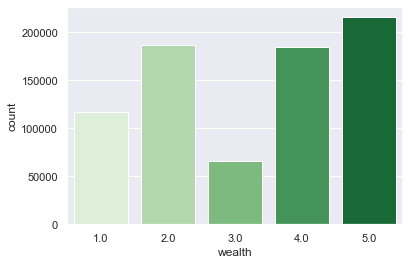

In [972]:
sns.countplot(azdias_drop_cat['wealth'], palette='Greens')

##### `life_stage`

In [973]:
# Raw count
azdias_drop_cat['life_stage'].value_counts()

1.0    236602
4.0    227348
3.0    116921
5.0    114678
2.0     75227
Name: life_stage, dtype: int64

In [974]:
# Ratios of counts
azdias_drop_cat['life_stage'].value_counts() / azdias_drop_cat['life_stage'].count() * 100

1.0    30.696597
4.0    29.495988
3.0    15.169258
5.0    14.878253
2.0     9.759904
Name: life_stage, dtype: float64

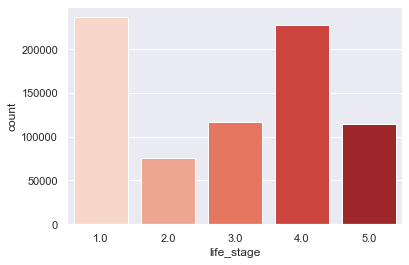

In [975]:
sns.countplot(azdias_drop_cat['life_stage'], palette='Reds')

##### Examine Other Mixed Categories

In [980]:
# Take a look at other mixed type attributes
fi_mixed = fi_drop_na.loc[fi_drop_na['type'] == 'mixed']
fi_mixed

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,[-1]


In [1030]:
# Examine other mixed type attributes in the dataframe
fi_mixed_cols = fi_mixed.loc[fi_mixed['attribute'].isin(['LP_LEBENSPHASE_FEIN',
                                                         'LP_LEBENSPHASE_GROB',
                                                         'WOHNLAGE'])]
mixed_cols = fi_mixed_cols['attribute']
azdias_drop_cat[mixed_cols].nunique()

LP_LEBENSPHASE_FEIN    40
LP_LEBENSPHASE_GROB    12
WOHNLAGE                8
dtype: int64

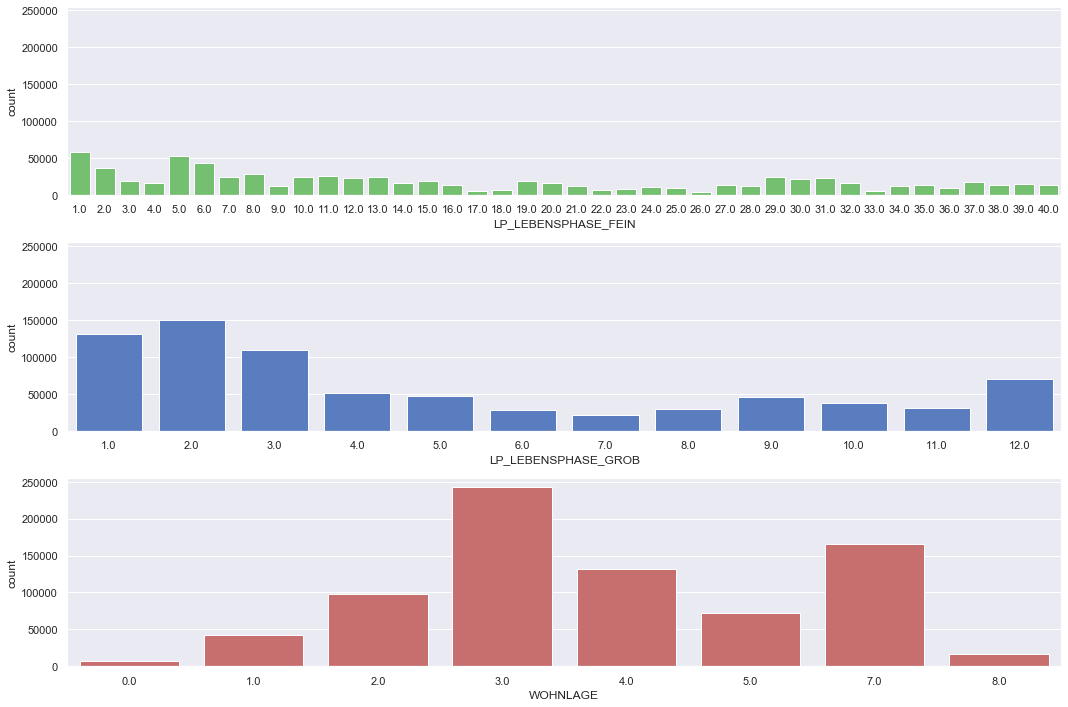

In [1033]:
# Plot mixed type features
f, axes = plt.subplots(3, 1, figsize=(15, 10), sharey=True)
colors = ['g','b','r']

for i, col in enumerate(mixed_cols):
    sns.countplot(azdias_drop_cat[col], color=colors[i], ax=axes[i])

plt.tight_layout()

We will drop the above features, as well as `PRAEGENDE_JUGENDJAHRE` and `CAMEO_INTL_2015` since we've engineered new features out of them:

In [1038]:
# Drop mixed type features from dataframe
azdias_drop_mix = azdias_drop_cat.drop(fi_mixed['attribute'], axis=1).copy()

In [1039]:
# Sanity check
print(fi_mixed['attribute'])
azdias_drop_mix.columns

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
Name: attribute, dtype: object


Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV',
       'ANZ_HH_TITEL', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ',
       'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER',
       'ONLINE_AFFINITAET', 'KBA13_ANZAHL_PKW', 'ARBEIT', 'ORTSGR_KLS9',
       'RELAT_AB', 'decade', 'movement', 'wealth', 'life_stage'],
      dtype='object')

#### Discussion 1.2.2: Engineer Mixed-Type Features

##### Summary

######  PRAEGENDE_JUGENDJAHRE

The breakdown of the PRAEGENDE_JUGENDJAHRE feature into decade and movement features reveal the following:

1. The number of persons who spent their youth in the 90s accounts for the highest count (29% of total), followed by the 70s (22%).  The least represented were those who spent their youth in the 40s and 50s (9.6% and 3.7% respectively).
2. The number of persons whose political alignment during their youth was with the mainstream far surpassed those who alinged themselves with the avant-garde (77.2% vs 22.7%)
3. Both features had a relatively small ratio of missing values at around 1.6% average.

######  CAMEO_INTL_2015

The breakdown of the CAMEO_INTL_2015 feature into wealth and life_stage features reveal the following:

1. The wealth distribution showed a highest representation of the poorest households (28% of distribution), followed by prosperous households (24%).  Overall the distribution had a U-shaped curve where the Comfortable households were least represented.
2. The life stage distribution showed pre-family households represented the most (30.7%), closely followed by older families & mature couples (29.5%).  The least represented group were young couples with children (9.8%).

###### Other Mixed Type Features

I've decided to remove other mixed type features as some have a large quantity of variables (`LP_LEBENSPHASE_FEIN` contain 40 unique variables) which would increase the dimension of the dataframe.  Additionally, features like `LP_LEBENSPHASE_FEIN` appear to be concatenated features that could be accounted for by other features (e.g. labels like "single homeowners of advanced age" which contain both homeowner status and age group).

In addition, since `PRAEGENDE_JUGENDJAHRE` and `CAMEO_INTL_2015` have been engineered to new feature I've dropped those features as well.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [1040]:
# Rename dataframe to final form
azdias_final = azdias_drop_mix.copy()

In [1041]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
azdias_final.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV',
       'ANZ_HH_TITEL', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ',
       'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER',
       'ONLINE_AFFINITAET', 'KBA13_ANZAHL_PKW', 'ARBEIT', 'ORTSGR_KLS9',
       'RELAT_AB', 'decade', 'movement', 'wealth', 'life_stage'],
      dtype='object')

In [1042]:
azdias_final.shape

(776413, 49)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [1150]:
def clean_data(df, fs):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    print('Copying dataframes')
    df = df.copy()
    fs = fs.copy()
    
    print('Converting missing/unknown values to NaN')
    df, fs = clean_x_values(df, fs)
    df = convert_unknown_data_to_nan(df, fs['missing_or_unknown'])
    
    print('Remove selected columns/rows')
    df, fs = drop_columns(df, fs)
    df = drop_rows(df)

    print('Re-encoding categorical features')
    df = reencode_categorical_features(df, fs)
    
    print('Engineering mixed type features')
    df = engineer_formative_features(df)
    df = engineer_wealth_life_stage_features(df)
    df = drop_mixed_features(df, fs)
    
    print('Done')
    return df

def clean_x_values(df, fs):
    # Step 1: Convert X/XX values in 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015' to -1
    x_columns = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']
    for col in x_columns:
        df[col] = df[col].replace({'X': -1,
                                   'XX': -1})

    # Step 2: Manually map XX values in CAMEO_DEU_2015 to NaN
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace({'XX': np.nan})

    # Step 3: Change 'X' and 'XX' values from the feature summary dataframe
    # Remove the 'X' value from these two attributes
    fs.loc[fs['attribute'] == 'CAMEO_DEUG_2015', 'missing_or_unknown'] = '[-1]'
    fs.loc[fs['attribute'] == 'CAMEO_INTL_2015', 'missing_or_unknown'] = '[-1]'

    # Since we already changed unknown values to NaN for this attribute,
    # convert the missing_or_unknown cell to an empty list
    fs.loc[fs['attribute'] == 'CAMEO_DEU_2015', 'missing_or_unknown'] = '[]'
    
    return df, fs

def convert_unknown_data_to_nan(df, unknown_data_series):
    """Reads in a dataframe and maps unknown data to NaN values
    Args:
        dataframe - Pandas dataframe
        unknown_data_series - Numpy series of lists that indicate 
            missing or unknown data.
    Returns:
        Dataframe where missing or unknown data is converted to NaN
    """
    for column, row in zip(df, unknown_data_series):
        # Skip over columns where there are no codes for missing/unknown values
        if row != '[]':
            # Convert string representation of a list to an actual list
            result = row.strip('][').split(',')
            # Convert string representation of integers to actual integers
            result_int = [int(i) for i in result]
            # Transform column with NaN values in place
            df[column] = df[column].map(
                lambda x: np.nan if x in result_int else x    
            )
    return df

def drop_columns(df, fs):
    ratio_missing = df.isna().mean()
    threshold = ratio_missing.quantile(0.75)
    nan_75 = np.where(df.isna().mean() >= threshold)
    drop_cols = df.columns[nan_75]
    df.drop(drop_cols, axis=1, inplace=True)
    
    # Remove corresponding columns in feature summary
    drop_index = fs.loc[fs['attribute'].isin(drop_cols)].index
    fi_drop_nan = fs.drop(drop_index, axis=0)
    return df, fi_drop_nan

def drop_rows(df):
    df_na = df.isna().mean(axis=1)
    df['nan_count'] = df_na
    df_low = df.loc[df['nan_count'] <= .1].copy()
    df_low.drop('nan_count', axis=1, inplace=True)
    return df_low

def reencode_categorical_features(df, fs):
    cat_cols = fs.loc[fs['type'] == 'categorical']['attribute']
    binary = []
    categorical = []

    for att in cat_cols:
        # Prevent errors thrown for dropped columns
        if att in df.columns:
            # Append features with binary values
            if len(df[att].value_counts()) <= 2:
                binary.append(att)
            # Append features with multilevel
            else:
                categorical.append(att)

    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({'W': 1, 'O': 0})
    df.drop(categorical, axis=1, inplace=True)
    return df

def engineer_formative_features(df):
    decades = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 
               9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    movement = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 
                9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}
    df['decade'] = df['PRAEGENDE_JUGENDJAHRE'].map(decades)
    df['movement'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement)
    return df

def engineer_wealth_life_stage_features(df):
    tens, ones = split_digits(df['CAMEO_INTL_2015'])
    df['wealth'] = tens
    df['life_stage'] = ones
    return df

def drop_mixed_features(df, fs):
    fi_mixed = fs.loc[fs['type'] == 'mixed']
    df.drop(fi_mixed['attribute'], axis=1, inplace=True)
    return df
    
def split_digits(series):
    """Takes in a numpy series and splits two-digit numbers by their
    first integer and second integer (e.g. 10 => 1 and 0), and appends
    each to separate lists
    
    Args:
        series - numpy series
    Returns:
        tens - list of the first integer extracted from numpy series
        ones - list of the second integer extracted from numpy series
    """
    tens = []
    ones = []
    for row in series:
        if not pd.isna(row):
            tens.append(int(str(row)[0]))
            ones.append(int(str(row)[1]))
        # Make sure to append NaN values, otherwise the index
        # will not match
        else:
            tens.append(None)
            ones.append(None)
    return tens, ones

In [1151]:
df = clean_data(azdias, feat_info)

Copying dataframes
Converting missing/unknown values to NaN
Remove selected columns/rows
Re-encoding categorical features
Engineering mixed type features
Done


In [1528]:
# sanity check
print(df.shape)
print(azdias_final.shape)

(776413, 49)
(776413, 49)


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [1190]:
# Examine ratio of missing values in each column
(df.isna().mean().round(4).sort_values(ascending=False) * 100).head(20)

HEALTH_TYP              2.59
VERS_TYP                2.59
movement                1.69
decade                  1.69
KBA13_ANZAHL_PKW        1.54
ANZ_HAUSHALTE_AKTIV     0.78
life_stage              0.73
wealth                  0.73
RELAT_AB                0.50
ARBEIT                  0.50
ORTSGR_KLS9             0.49
ANZ_HH_TITEL            0.45
ALTERSKATEGORIE_GROB    0.34
BALLRAUM                0.07
EWDICHTE                0.07
INNENSTADT              0.07
KONSUMNAEHE             0.01
OST_WEST_KZ             0.00
FINANZ_HAUSBAUER        0.00
SEMIO_REL               0.00
dtype: float64

In [1239]:
# Examine ratio of missing values for all rows
df.isna().mean(axis=1).sort_values(ascending=False).head(20)

673695    0.122449
340685    0.122449
485886    0.122449
798560    0.122449
731159    0.122449
661751    0.122449
237267    0.122449
566756    0.122449
125468    0.122449
136167    0.122449
740562    0.122449
331434    0.122449
312728    0.102041
629082    0.102041
592793    0.102041
860363    0.102041
300838    0.102041
848298    0.102041
80385     0.102041
508977    0.102041
dtype: float64

In [1248]:
# How many rows have missing values
rows_missing_values = (df.isna().sum(axis=1) > 0).sum()
print('Sum of rows with missing values')
print(rows_missing_values, '\n')

# Percentage of rows with missing values to entire dataframe
print('Percentage of rows with missing values')
print(f'{round(rows_missing_values / df.shape[0] * 100, 2)}%')

Sum of rows with missing values
54479 

Percentage of rows with missing values
7.02%


In [1257]:
# How many cells have missing values
missing_cells = df.isna().sum().sum()
print(f'Total cells with missing values:', missing_cells, '\n')

missing_cell_ratio = round(missing_cells / np.prod(df.shape) * 100, 2)
# Percentage of cells with missing values
print(f'Percentage of cells with missing values:', missing_cell_ratio, '%')

Total cells with missing values: 115027 

Percentage of cells with missing values: 0.3 %


##### Apply feature scaling to the general population demographics data.

In [1529]:
# Impute NaNs from the dataframe using SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
df_impute = imputer.fit_transform(df)

In [1530]:
df_impute

array([[1., 2., 1., ..., 0., 5., 1.],
       [3., 2., 1., ..., 1., 2., 4.],
       [4., 2., 4., ..., 0., 1., 2.],
       ...,
       [2., 2., 2., ..., 0., 2., 4.],
       [1., 1., 1., ..., 0., 5., 1.],
       [4., 1., 4., ..., 0., 4., 3.]])

In [1569]:
# Apply feature scaling using the imputed data
scaler = StandardScaler().fit(df_impute)
df_imp_scaled = scaler.transform(df_impute)

In [1570]:
# Create a new dataframe using the scaled features
df_ss = pd.DataFrame(df_imp_scaled, columns=df.columns)

In [1571]:
df_ss.shape

(776413, 49)

In [1534]:
df_ss.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,ONLINE_AFFINITAET,KBA13_ANZAHL_PKW,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,wealth,life_stage
0,-1.744987,0.966074,-1.533344,1.580519,-1.044529,1.508054,0.988405,1.361284,-0.536804,1.074418,-1.666112,0.432268,-0.051716,0.031940,-0.456068,-1.712144,-1.091289,-1.433129,-0.574028,1.279100,-0.304810,1.330115,-0.148242,1.545916,1.269686,10.857310,0.977460,0.229487,-0.060457,1.031031,0.567871,0.176794,-0.125426,-1.310738,-0.384770,0.52071,0.843230,-0.540455,1.698282,-0.805629,0.157301,1.015993,-0.165918,-0.122401,0.687957,1.153957,-0.547397,1.196793,-1.272393
1,0.203528,0.966074,-1.533344,0.900133,-1.766752,-0.550092,0.268969,1.361284,1.862878,1.074418,-0.289689,-0.081611,-1.610886,-0.498014,-0.456068,-0.161911,-0.140162,0.762423,-0.574028,0.072905,1.393471,1.330115,1.449112,-0.619727,-0.419009,-0.092104,-1.050214,-0.637592,-0.060457,-0.261383,0.567871,0.112052,-0.125426,1.268955,-0.384770,0.52071,-0.990515,0.041061,-0.275257,0.279219,-0.484990,0.272584,-0.165918,-0.122401,-0.785663,1.153957,1.858255,-0.858842,0.756948
2,1.177785,0.966074,0.664987,-0.460638,1.122139,-0.550092,-1.169903,-0.776686,-0.536804,-0.267381,-0.977900,0.432268,-1.610886,-1.027967,-1.493295,-0.161911,-0.140162,1.311311,-0.066885,-0.530193,-0.304810,-0.298581,0.384210,-0.078316,0.143889,-0.092104,-1.050214,-1.504671,-0.060457,-2.200004,0.567871,-0.470623,-0.125426,0.624031,1.118008,0.52071,-0.073642,-1.121971,0.711513,0.279219,-1.127282,-0.070983,-1.167637,-0.992478,-0.048853,-0.230725,-0.547397,-1.544054,-0.595946
3,0.203528,-1.035117,0.664987,0.219748,0.399916,-1.236141,0.268969,-0.776686,-0.536804,1.074418,1.086735,0.946146,-0.051716,0.031940,-0.974682,1.388321,-0.140162,-0.335353,0.947402,-1.133291,-0.870904,-1.384379,-1.213145,-0.078316,-0.981908,-0.092104,0.977460,1.963646,-0.060457,0.384824,0.567871,-0.341139,-0.125426,0.624031,-0.384770,0.52071,-0.990515,0.622577,-1.755411,1.364067,1.441883,-0.547831,0.835802,0.312638,1.424767,-0.230725,-0.547397,0.511581,0.080501
4,-1.744987,0.966074,-0.067790,-1.141024,1.122139,-0.550092,-0.450467,1.361284,-0.536804,1.074418,-0.289689,-1.109368,-0.051716,1.621801,0.062546,-1.195400,-1.091289,-1.433129,0.440258,1.882198,-0.304810,-0.298581,-0.148242,1.545916,1.269686,-0.092104,0.977460,-0.637592,-0.060457,0.384824,0.567871,-0.211656,-0.125426,1.268955,-0.384770,0.52071,0.843230,-1.121971,1.204897,0.279219,-1.127282,2.014116,-1.167637,-0.992478,-0.048853,-1.615407,-0.547397,1.196793,0.756948


In [1535]:
df_ss.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,ONLINE_AFFINITAET,KBA13_ANZAHL_PKW,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,wealth,life_stage
count,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05,7.764130e+05
mean,-5.568570e-16,1.294495e-16,1.095997e-16,-7.866722e-17,2.394061e-17,-1.694878e-17,2.910211e-17,9.036298e-17,4.981220e-17,-1.011902e-15,-2.016099e-17,-2.697070e-16,-7.174861e-18,7.767885e-17,5.783816e-18,-1.280493e-16,1.630450e-16,-7.467712e-18,8.734295e-17,-1.509649e-16,-1.118326e-17,-1.703480e-16,8.686706e-17,-1.222655e-17,5.846047e-17,-4.949190e-17,5.359456e-16,-2.196386e-19,1.711351e-18,-2.525752e-16,3.829033e-17,1.579568e-16,9.810524e-18,-2.061638e-15,2.289891e-14,-1.352242e-16,-2.606927e-16,9.388406e-16,3.201965e-16,-2.608391e-16,6.311864e-17,-5.432577e-16,-6.600140e-17,4.046292e-16,1.431540e-15,-1.641213e-15,-4.441275e-17,7.229770e-18,3.046021e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.744987e+00,-1.035117e+00,-1.533344e+00,-1.141024e+00,-1.766752e+00,-1.236141e+00,-1.169903e+00,-1.489343e+00,-5.368039e-01,-1.609180e+00,-1.666112e+00,-1.623247e+00,-1.610886e+00,-1.557921e+00,-1.493295e+00,-1.712144e+00,-1.566852e+00,-1.982017e+00,-1.588315e+00,-1.736388e+00,-2.003091e+00,-1.927277e+00,-1.745596e+00,-1.702549e+00,-1.544806e+00,-9.210384e-02,-1.050214e+00,-1.504671e+00,-6.045712e-02,-2.200004e+00,-3.591112e+00,-4.706228e-01,-1.254258e-01,-1.310738e+00,-2.488660e+00,-1.920454e+00,-1.448951e+00,-1.703487e+00,-1.755411e+00,-2.975325e+00,-1.769573e+00,-1.836209e+00,-2.169356e+00,-1.862555e+00,-1.522473e+00,-2.307748e+00,-5.473972e-01,-1.544054e+00,-1.272393e+00
25%,-7.707294e-01,-1.035117e+00,-8.005672e-01,-1.141024e+00,-1.044529e+00,-1.236141e+00,-1.169903e+00,-7.766864e-01,-5.368039e-01,-2.673813e-01,-9.779003e-01,-1.109368e+00,-1.091163e+00,-4.980135e-01,-9.746817e-01,-1.195400e+00,-1.091289e+00,-8.842414e-01,-5.740284e-01,-5.301928e-01,-8.709036e-01,-8.414798e-01,-6.806931e-01,-6.197271e-01,-9.819076e-01,-9.210384e-02,-1.050214e+00,-6.375919e-01,-6.045712e-02,-9.075901e-01,4.799839e-02,-4.058812e-01,-1.254258e-01,-6.658148e-01,-3.847702e-01,5.207101e-01,-9.905146e-01,-1.121971e+00,-7.686415e-01,-8.056289e-01,-1.127282e+00,-6.929588e-01,-1.659176e-01,-5.574392e-01,-7.856632e-01,-9.230656e-01,-5.473972e-01,-8.588420e-01,-1.272393e+00
50%,2.035279e-01,9.660742e-01,-6.779018e-02,-4.606

### Discussion 2.1: Apply Feature Scaling

The cleaned dataframe had a total of 54,479 rows with missing values, accounting for 7.02% of all rows.  In terms of total cells with missing values, there were a total of 115,027 cells with missing values, accounting for 0.3% of all cells.

The SimpleImputer class was used to impute the missing values using the mean strategy, ie. missing values were replaced using the mean along each column.  This imputed result was then applied to the StandardScaler, which was then used as the input data to create a new dataframe.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

##### Apply PCA to the data

In [1536]:
# Helper functions from PCA modules

def pca_results(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    
    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

def scree_plot(pca, figsize=(20, 5)):
    '''
    Creates a scree plot associated with the principal components

    INPUT: pca - the result of instantian of PCA in scikit learn
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_

    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % (
            (str(vals[i]*100)[:4])),
            (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=10)

    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)

    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

In [1537]:
# Apply PCA to the data using defaults
pca_1 = PCA()
X_pca_1 = pca_1.fit_transform(df_ss)

In [1538]:
X_pca_1.shape

(776413, 49)

In [1539]:
# Use helper function from PCA module
pca_results(df, pca_1)

,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,ONLINE_AFFINITAET,KBA13_ANZAHL_PKW,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,wealth,life_stage
Dimension 1,0.1844,-0.2879,-0.0675,-0.1824,0.2818,-0.2590,0.2104,0.2328,-0.0053,-0.0482,0.0663,-0.1524,0.1092,0.1940,0.2776,0.1793,0.0330,-0.1990,-0.2376,0.2217,0.1996,-0.0912,-0.0416,-0.0682,0.2573,0.2479,0.0003,-0.0127,0.0011,-0.0085,0.0689,-0.0867,0.0256,-0.0055,-0.0383,0.0093,-0.0100,-0.0249,0.0370,-0.0346,-0.0316,0.1125,-0.0167,0.0287,0.0395,0.0252,0.2669,-0.0502,0.0549,-0.0729
Dimension 2,0.1313,-0.0434,0.3124,-0.2417,0.0802,-0.0585,0.0950,0.0270,0.1947,-0.1137,0.0184,-0.0303,-0.2015,-0.2055,-0.0805,-0.0526,-0.3117,-0.0303,0.1651,-0.2095,0.1587,0.2518,0.2795,0.3215,0.0460,0.0355,-0.0027,0.0284,-0.0814,-0.0070,0.1806,-0.0441,0.1046,0.0315,-0.1238,-0.0576,-0.0386,-0.1028,0.1534,-0.1288,-0.0837,-0.0605,-0.0607,0.1195,0.1553,0.1115,0.0482,-0.1127,0.1545,-0.0824
Dimension 3,0.1109,0.0688,-0.2065,-0.0541,-0.0600,0.0824,-0.1797,-0.1174,0.1760,-0.0703,-0.0113,0.1448,0.1726,0.1548,0.0306,0.0271,0.1677,0.0699,-0.0827,0.1270,-0.1470,-0.1329,-0.1570,-0.1415,-0.0563,-0.0843,-0.0028,0.0571,-0.1110,0.0068,0.1992,0.0004,0.1714,0.0623,-0.2158,-0.1105,-0.0669,-0.1920,0.2717,-0.2363,-0.1540,-0.1654,-0.1145,0.2138,0.2759,0.1986,-0.1074,-0.0689,0.2369,-0.1202
Dimension 4,0.0602,-0.0445,0.0362,0.0989,-0.0028,-0.0174,-0.1159,0.0982,-0.1582,0.4552,0.0121,0.0003,0.0020,-0.0301,0.0015,-0.0053,-0.0115,-0.0026,-0.0166,-0.0214,0.0515,0.0166,0.1100,0.0911,0.0290,0.0501,0.0034,0.0244,0.1354,0.0530,-0.2931,0.0224,-0.0530,0.0214,-0.1072,0.0023,0.1324,-0.2616,0.2749,-0.2408,-0.0500,0.1716,-0.0019,0.0638,0.2706,0.1044,0.0464,0.4542,-0.1594,0.0791
Dimension 5,0.0333,-0.0395,0.0102,-0.0498,-0.0395,0.1343,-0.1302,0.0534,0.0335,-0.0182,0.0053,0.1075,-0.0057,0.0449,0.0549,0.0914,-0.0336,0.0200,-0.0360,0.0095,0.0765,0.0454,0.0240,-0.0001,0.0690,0.0799,-0.0031,0.0042,-0.1268,0.0894,0.0175,-0.0170,0.2011,0.2205,-0.2153,-0.1253,0.4295,-0.0969,0.0230,-0.0118,-0.2364,-0.1353,0.3352,-0.4862,-0.0642,-0.3171,-0.0570,-0.0161,-0.0292,-0.0711
Dimension 6,0.0321,-0.0365,0.1124,0.0536,-0.1607,0.1008,-0.1110,-0.1377,0.1126,0.0240,-0.4418,0.0750,-0.0978,0.0381,0.1498,0.3984,-0.0240,0.0679,-0.0007,0.0395,0.2694,-0.0537,-0.0128,0.0605,0.1246,0.2280,0.0023,-0.5085,-0.0076,0.0316,-0.0314,0.1042,-0.0139,0.0134,0.0340,0.0469,-0.1261,0.0151,-0.0167,0.0003,0.0341,-0.0934,-0.0484,0.0911,-0.0044,0.0291,-0.1857,0.0258,-0.0192,0.0868
Dimension 7,0.0296,0.1424,0.0174,-0.1668,0.1481,-0.1782,0.1694,0.1305,0.1404,0.1142,-0.3186,-0.2380,0.0246,-0.0434,-0.1067,-0.0477,0.0688,0.1977,0.0892,-0.1031,-0.1454,-0.1196,-0.1372,-0.0570,-0.1693,-0.1393,0.0065,-0.1798,0.1124,0.2180,-0.0079,-0.1075,0.2662,0.3714,-0.0786,0.0313,-0.2011,0.0291,-0.0674,0.0344,-0.1904,0.1771,0.0021,-0.0317,-0.0330,-0.1037,0.1204,0.1178,0.0132,0.0327
Dimension 8,0.0273,-0.1505,0.0188,0.0393,-0.0811,0.0765,0.0258,-0.2116,0.1212,0.0731,0.2403,0.0293,0.0636,0.0051,0.0873,-0.0781,-0.0866,-0.0818,-0.0828,0.0648,0.0885,-0.0230,0.1017,0.0083,0.1201,0.1089,0.0091,0.2476,0.1686,0.3172,-0.0175,0.3058,0.2182,0.4006,0.1054,-0.3086,-0.2028,0.1168,-0.0904,0.0977,0.0372,-0.0645,-0.0773,0.1021,-0.0561,0.0189,-0.0858,0.0710,-0.0535,0.1974
Dimension 9,0.0261,-0.0052,-0.0405,0.1598,-0.0718,-0.0477,-0.0733,-0.0446,-0.2530,-0.1312,0.1946,0.1557,-0.0686,0.0226,-0.0263,0.0926,0.0429,-0.1577,-0.0173,-0.0023,0.0302,0.1605,0.0404,0.0207,-0.0194,0.0302,-0.0150,-0.0057,-0.2473,0.2015,-0.1229,-0.3034,0.1623,0.3204,0.0458,0.54

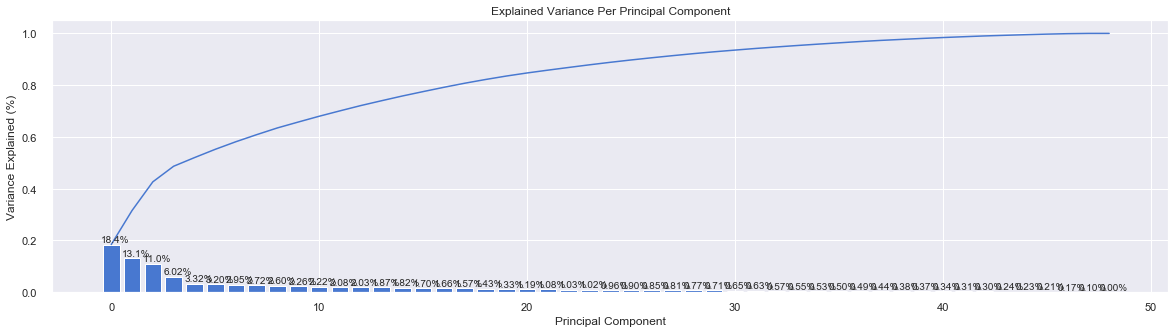

In [1389]:
# Use the scree_plot function from PCA module
scree_plot(pca_1, (20,5))

In [1540]:
# Try with a smaller number of componenets
pca_2 = PCA(n_components=25)
X_pca_2 = pca_2.fit_transform(df_ss)

In [1541]:
X_pca_2.shape

(776413, 25)

In [1542]:
pca_results(df, pca_2)

,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,ONLINE_AFFINITAET,KBA13_ANZAHL_PKW,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,wealth,life_stage
Dimension 1,0.1844,-0.2879,-0.0675,-0.1824,0.2818,-0.2590,0.2104,0.2328,-0.0053,-0.0482,0.0663,-0.1524,0.1092,0.1940,0.2776,0.1793,0.0330,-0.1990,-0.2376,0.2217,0.1996,-0.0912,-0.0416,-0.0682,0.2573,0.2479,0.0003,-0.0127,0.0011,-0.0085,0.0689,-0.0867,0.0256,-0.0055,-0.0383,0.0093,-0.0100,-0.0249,0.0370,-0.0346,-0.0316,0.1125,-0.0167,0.0287,0.0395,0.0252,0.2669,-0.0502,0.0549,-0.0729
Dimension 2,0.1313,-0.0434,0.3124,-0.2417,0.0802,-0.0585,0.0950,0.0270,0.1947,-0.1137,0.0184,-0.0303,-0.2015,-0.2055,-0.0805,-0.0526,-0.3117,-0.0303,0.1651,-0.2095,0.1587,0.2518,0.2795,0.3215,0.0460,0.0355,-0.0027,0.0284,-0.0814,-0.0070,0.1806,-0.0441,0.1046,0.0315,-0.1238,-0.0576,-0.0386,-0.1028,0.1534,-0.1288,-0.0837,-0.0605,-0.0607,0.1195,0.1553,0.1115,0.0482,-0.1127,0.1545,-0.0824
Dimension 3,0.1109,0.0688,-0.2065,-0.0541,-0.0600,0.0824,-0.1797,-0.1174,0.1760,-0.0703,-0.0113,0.1448,0.1726,0.1548,0.0306,0.0271,0.1677,0.0699,-0.0827,0.1270,-0.1470,-0.1329,-0.1570,-0.1415,-0.0563,-0.0843,-0.0028,0.0571,-0.1110,0.0068,0.1992,0.0004,0.1714,0.0623,-0.2158,-0.1105,-0.0669,-0.1920,0.2717,-0.2363,-0.1540,-0.1654,-0.1145,0.2138,0.2759,0.1986,-0.1074,-0.0689,0.2369,-0.1202
Dimension 4,0.0602,-0.0445,0.0362,0.0989,-0.0028,-0.0174,-0.1159,0.0982,-0.1582,0.4552,0.0121,0.0003,0.0020,-0.0301,0.0015,-0.0053,-0.0115,-0.0026,-0.0166,-0.0214,0.0515,0.0166,0.1100,0.0911,0.0290,0.0501,0.0034,0.0244,0.1354,0.0530,-0.2931,0.0224,-0.0530,0.0214,-0.1072,0.0023,0.1324,-0.2616,0.2749,-0.2408,-0.0500,0.1716,-0.0019,0.0638,0.2706,0.1044,0.0464,0.4542,-0.1594,0.0791
Dimension 5,0.0333,-0.0395,0.0102,-0.0498,-0.0395,0.1343,-0.1302,0.0534,0.0335,-0.0182,0.0053,0.1075,-0.0057,0.0449,0.0549,0.0914,-0.0336,0.0200,-0.0360,0.0095,0.0765,0.0454,0.0240,-0.0001,0.0690,0.0799,-0.0031,0.0042,-0.1268,0.0894,0.0175,-0.0170,0.2011,0.2205,-0.2153,-0.1253,0.4295,-0.0969,0.0230,-0.0118,-0.2364,-0.1353,0.3352,-0.4862,-0.0642,-0.3171,-0.0570,-0.0161,-0.0292,-0.0711
Dimension 6,0.0321,-0.0365,0.1124,0.0536,-0.1607,0.1008,-0.1109,-0.1377,0.1126,0.0240,-0.4418,0.0750,-0.0978,0.0382,0.1498,0.3984,-0.0240,0.0679,-0.0007,0.0395,0.2693,-0.0536,-0.0128,0.0605,0.1246,0.2281,0.0023,-0.5086,-0.0076,0.0316,-0.0314,0.1042,-0.0139,0.0134,0.0340,0.0469,-0.1261,0.0151,-0.0167,0.0003,0.0341,-0.0934,-0.0484,0.0912,-0.0044,0.0292,-0.1857,0.0258,-0.0193,0.0868
Dimension 7,0.0296,0.1424,0.0174,-0.1668,0.1481,-0.1782,0.1694,0.1305,0.1404,0.1142,-0.3186,-0.2380,0.0246,-0.0433,-0.1067,-0.0477,0.0688,0.1977,0.0892,-0.1031,-0.1454,-0.1195,-0.1372,-0.0570,-0.1693,-0.1392,0.0065,-0.1798,0.1124,0.2180,-0.0079,-0.1075,0.2662,0.3714,-0.0786,0.0313,-0.2010,0.0291,-0.0674,0.0344,-0.1904,0.1771,0.0021,-0.0317,-0.0330,-0.1037,0.1204,0.1178,0.0132,0.0327
Dimension 8,0.0273,-0.1505,0.0188,0.0393,-0.0811,0.0765,0.0258,-0.2115,0.1212,0.0731,0.2403,0.0292,0.0637,0.0049,0.0874,-0.0780,-0.0866,-0.0818,-0.0828,0.0648,0.0886,-0.0231,0.1016,0.0083,0.1201,0.1088,0.0091,0.2476,0.1685,0.3172,-0.0175,0.3059,0.2182,0.4006,0.1054,-0.3086,-0.2028,0.1168,-0.0903,0.0978,0.0372,-0.0645,-0.0773,0.1020,-0.0560,0.0189,-0.0858,0.0709,-0.0535,0.1974
Dimension 9,0.0261,-0.0052,-0.0405,0.1599,-0.0718,-0.0477,-0.0734,-0.0445,-0.2530,-0.1313,0.1946,0.1557,-0.0686,0.0224,-0.0263,0.0927,0.0429,-0.1577,-0.0173,-0.0023,0.0303,0.1604,0.0404,0.0208,-0.0194,0.0301,-0.0150,-0.0057,-0.2473,0.2015,-0.1229,-0.3034,0.1623,0.3204,0.0458,0.54

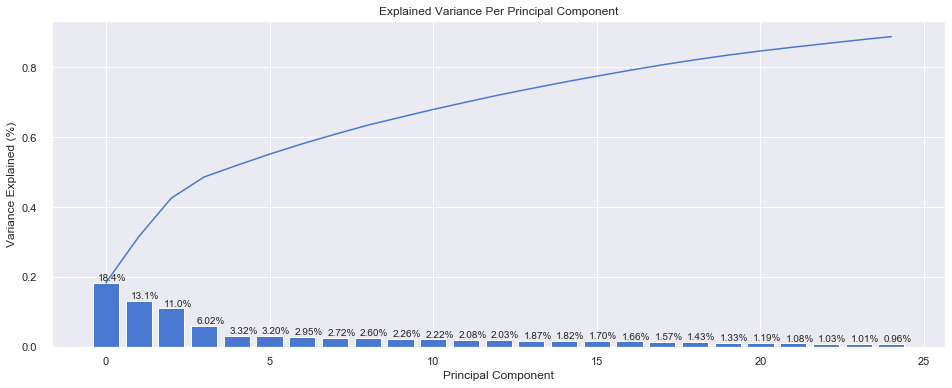

In [1543]:
scree_plot(pca_2, figsize=(16,6))

The variance appears to stabilize around 15 components. We'll select n=15 as the number of transformed features to retain for the clustering part of the project. 

In [1544]:
# Another try with an even smaller n-count
pca_3 = PCA(n_components=15)
X_pca_3 = pca_3.fit_transform(df_ss)

In [1545]:
pca_results(df, pca_3)

,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,ONLINE_AFFINITAET,KBA13_ANZAHL_PKW,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,wealth,life_stage
Dimension 1,0.1844,-0.2879,-0.0675,-0.1824,0.2818,-0.2590,0.2104,0.2328,-0.0053,-0.0482,0.0663,-0.1524,0.1092,0.1940,0.2776,0.1793,0.0330,-0.1990,-0.2376,0.2217,0.1996,-0.0912,-0.0416,-0.0682,0.2573,0.2479,0.0003,-0.0127,0.0011,-0.0085,0.0689,-0.0867,0.0256,-0.0055,-0.0383,0.0093,-0.0100,-0.0249,0.0370,-0.0346,-0.0316,0.1125,-0.0167,0.0287,0.0395,0.0252,0.2669,-0.0502,0.0549,-0.0729
Dimension 2,0.1313,-0.0434,0.3124,-0.2417,0.0802,-0.0585,0.0950,0.0270,0.1947,-0.1137,0.0184,-0.0303,-0.2015,-0.2055,-0.0805,-0.0526,-0.3117,-0.0303,0.1651,-0.2095,0.1587,0.2518,0.2795,0.3215,0.0460,0.0355,-0.0027,0.0284,-0.0814,-0.0070,0.1806,-0.0441,0.1046,0.0315,-0.1238,-0.0576,-0.0386,-0.1028,0.1534,-0.1288,-0.0837,-0.0605,-0.0607,0.1195,0.1553,0.1115,0.0482,-0.1127,0.1545,-0.0824
Dimension 3,0.1109,0.0688,-0.2065,-0.0541,-0.0600,0.0824,-0.1797,-0.1174,0.1760,-0.0703,-0.0113,0.1448,0.1726,0.1548,0.0306,0.0271,0.1677,0.0699,-0.0827,0.1270,-0.1470,-0.1329,-0.1570,-0.1415,-0.0563,-0.0843,-0.0028,0.0571,-0.1110,0.0068,0.1992,0.0004,0.1714,0.0622,-0.2158,-0.1105,-0.0669,-0.1920,0.2717,-0.2363,-0.1540,-0.1654,-0.1145,0.2138,0.2759,0.1986,-0.1074,-0.0689,0.2369,-0.1202
Dimension 4,0.0602,-0.0445,0.0362,0.0989,-0.0028,-0.0174,-0.1159,0.0982,-0.1582,0.4552,0.0121,0.0002,0.0020,-0.0301,0.0015,-0.0053,-0.0115,-0.0026,-0.0166,-0.0214,0.0515,0.0166,0.1100,0.0912,0.0291,0.0502,0.0034,0.0244,0.1354,0.0530,-0.2931,0.0224,-0.0530,0.0214,-0.1072,0.0023,0.1324,-0.2616,0.2749,-0.2408,-0.0500,0.1716,-0.0019,0.0638,0.2706,0.1044,0.0464,0.4542,-0.1594,0.0791
Dimension 5,0.0333,-0.0395,0.0102,-0.0499,-0.0395,0.1344,-0.1301,0.0533,0.0336,-0.0182,0.0054,0.1076,-0.0058,0.0451,0.0549,0.0913,-0.0336,0.0201,-0.0358,0.0095,0.0764,0.0455,0.0238,-0.0001,0.0693,0.0798,-0.0031,0.0042,-0.1268,0.0893,0.0176,-0.0169,0.2008,0.2208,-0.2151,-0.1252,0.4296,-0.0969,0.0230,-0.0121,-0.2366,-0.1352,0.3353,-0.4862,-0.0643,-0.3171,-0.0570,-0.0161,-0.0290,-0.0711
Dimension 6,0.0321,-0.0365,0.1125,0.0543,-0.1608,0.1004,-0.1112,-0.1379,0.1119,0.0234,-0.4421,0.0740,-0.0969,0.0386,0.1499,0.3982,-0.0241,0.0686,-0.0002,0.0395,0.2694,-0.0535,-0.0125,0.0610,0.1254,0.2284,0.0021,-0.5080,-0.0069,0.0317,-0.0317,0.1037,-0.0143,0.0141,0.0339,0.0463,-0.1263,0.0150,-0.0166,0.0002,0.0344,-0.0946,-0.0480,0.0915,-0.0042,0.0293,-0.1858,0.0253,-0.0199,0.0863
Dimension 7,0.0296,0.1426,0.0174,-0.1659,0.1479,-0.1786,0.1691,0.1298,0.1393,0.1139,-0.3192,-0.2392,0.0243,-0.0426,-0.1066,-0.0477,0.0688,0.1980,0.0898,-0.1028,-0.1454,-0.1196,-0.1368,-0.0567,-0.1687,-0.1389,0.0064,-0.1791,0.1133,0.2182,-0.0075,-0.1081,0.2657,0.3724,-0.0793,0.0308,-0.2014,0.0286,-0.0673,0.0349,-0.1896,0.1763,0.0024,-0.0316,-0.0327,-0.1041,0.1203,0.1175,0.0139,0.0335
Dimension 8,0.0273,-0.1511,0.0185,0.0370,-0.0808,0.0780,0.0266,-0.2109,0.1245,0.0750,0.2424,0.0331,0.0616,0.0039,0.0875,-0.0780,-0.0868,-0.0843,-0.0847,0.0647,0.0884,-0.0223,0.1006,0.0069,0.1182,0.1079,0.0096,0.2463,0.1661,0.3167,-0.0171,0.3085,0.2193,0.3981,0.1067,-0.3078,-0.2022,0.1183,-0.0907,0.0973,0.0357,-0.0611,-0.0787,0.1012,-0.0570,0.0189,-0.0858,0.0729,-0.0526,0.1979
Dimension 9,0.0261,-0.0054,-0.0403,0.1591,-0.0717,-0.0473,-0.0730,-0.0444,-0.2519,-0.1312,0.1953,0.1569,-0.0676,0.0226,-0.0266,0.0928,0.0429,-0.1586,-0.0171,-0.0026,0.0306,0.1600,0.0404,0.0211,-0.0200,0.0301,-0.0147,-0.0059,-0.2483,0.2023,-0.1240,-0.3022,0.1639,0.3193,0.0462,0.54

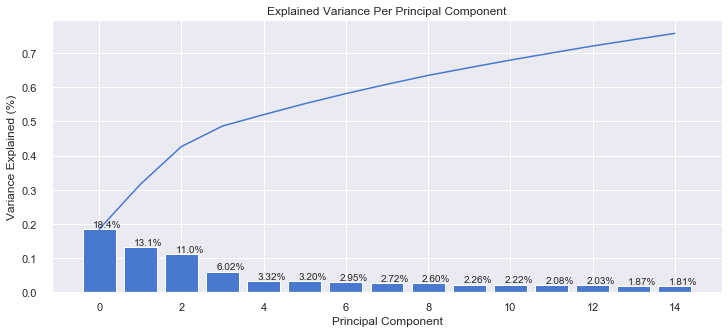

In [1546]:
scree_plot(pca_3, figsize=(12,5))

In [1547]:
# Construct a new dataframe with the reduced features
df_pca = pd.DataFrame(X_pca_3)
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,4.101296,2.836753,-1.365660,-1.360024,0.820668,-1.499982,-0.009333,1.269167,-2.072860,-0.006620,1.367051,1.083530,10.838145,-0.090436,0.710758
1,-0.582230,2.205802,-1.978834,2.060222,0.185809,-0.618671,0.852982,0.126370,-0.697180,-1.326195,-1.543714,0.154466,-0.055885,0.900980,-1.675358
2,-2.938485,-0.779867,-2.117742,-0.757778,0.367968,0.251580,-0.365348,-0.859661,0.872279,-0.338404,0.014068,0.080067,-0.079137,0.271298,-0.725756
3,-0.169022,-2.256508,2.539465,0.851924,-1.748049,-1.983295,-1.142657,0.236709,-0.456791,1.983802,1.185373,2.233935,-0.754733,-0.212769,0.141915
4,0.997506,0.170691,-1.467959,-2.210485,2.167018,1.360325,-3.078649,2.505901,-0.765195,-0.916270,-0.679136,0.097411,-0.027249,-0.702200,1.247262


### Discussion 2.2: Perform Dimensionality Reduction

Using the visualization functions, we can see that the explained variance per principal component reaches its elbow around 5-6 principal components and stabilizes at around 10-15 components. After 10-15 componenets the ratio of variance explained becomes marginal.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [1615]:
def print_component(pca, comp):
    weight_df = pd.DataFrame(np.round(pca.components_, 3), columns=df.columns)
    weights_sorted = weight_df.iloc[comp - 1].sort_values(ascending=False)
    print("Most weighted features for component", comp, '\n')
    print(weights_sorted.head(5), '\n')
    print(weights_sorted.tail(5).sort_values())

In [1616]:
# Component 1
print_component(pca_3, 1)

Most weighted features for component 1 

FINANZ_SPARER    0.282
SEMIO_REL        0.278
decade           0.267
SEMIO_PFLICHT    0.257
SEMIO_TRADV      0.248
Name: 0, dtype: float64 

ALTERSKATEGORIE_GROB   -0.288
FINANZ_VORSORGER       -0.259
SEMIO_ERL              -0.238
SEMIO_LUST             -0.199
FINANZ_MINIMALIST      -0.182
Name: 0, dtype: float64


##### Component 1 Interpetations

Below are the mappings of the features from the data dictionary:

##### Most Positive Features:

1. FINANZ_SPARER - Financial typology (1: very high, 5: very low); SPARER: money-saver
2. SEMIO_REL - Personality typology (1: highest affinity, 7: lowest affinity); REL: religious
3. decade - Formative years (1:40s , 6:90s)
4. SEMIO_PFLICHT - Personality typology; PFLICHT: dutiful
5. SEMIO_TRADV - Personality typology; TRADV: tradional-minded 

##### Most Negative Features:
1. ALTERSKATEGORIE_GROB   - Estimated age based on given name analysis (1: < 30 years old, 4: > 60 years old, 9: uniformly distributed)
2. FINANZ_VORSORGER       - Financial typology; VORSORGER: be prepared
3. SEMIO_ERL              - Personality typology; ERL: event-oriented
4. SEMIO_LUST             - Personality typology; LUST: sensual-minded
5. FINANZ_MINIMALIST      - Financial typology ; MINIMALIST: low financial interest


##### Interpretation

Both positive weights group personality traits and finance.  

The positive weights show a population with a lower affinity for traditional values (relgion, dutiful, traditional), younger (90s) and low affinity for money-saving

The negative weights show a population with a high affinity for fiscal conservatism and high affinity for sensual/event-oriented personality.

In [1617]:
# Component 2
print_component(pca_3, 2)

Most weighted features for component 2 

SEMIO_KAEM          0.321
ANREDE_KZ           0.312
SEMIO_DOM           0.279
SEMIO_KRIT          0.252
FINANZ_HAUSBAUER    0.195
Name: 1, dtype: float64 

SEMIO_VERT          -0.312
FINANZ_MINIMALIST   -0.242
SEMIO_KULT          -0.210
SEMIO_FAM           -0.206
SEMIO_SOZ           -0.202
Name: 1, dtype: float64


##### Component 2 Interpetations

Below are the mappings of the features from the data dictionary:

##### Most Positive Features:

1. SEMIO_KAEM - Personality typology (1: highest affinity, 7: lowest affinity); KAEM: combative attitude
2. ANREDE_KZ - Gender (1: Male, 2:Female)
3. SEMIO_DOM - Personality typology; DOM: dominant-minded   
4. SEMIO_KRIT - Personality typology; KRIT: critical-minded
5. FINANZ_HAUSBAUER - Financial typology (1: very high, 5: very low); HAUSBAUER: home ownership

##### Most Negative Features:
1. SEMIO_VERT - Personality typology; VERT: dreamful
2. FINANZ_MINIMALIST - Financial typology (1: very high, 5: very low); MINIMALIST: low financial interest
3. SEMIO_KULT - Personality typology; KULT: cultural-minded
4. SEMIO_FAM - Personality typology; FAM: family-minded
5. SEMIO_SOZ - Personality typology(1: highest affinity, 7: lowest affinity); SOZ: socially-minded

##### Interpretation

The second component groups mainly personality traits.  Both positive and negative features show an affinity for a social/culturally minded population with low affinity toward combativeness and dominant-minded personalities.  The population also leaned towards female.

In [1618]:
# Component 3
print_component(pca_3, 3)

Most weighted features for component 3 

ORTSGR_KLS9    0.276
EWDICHTE       0.272
wealth         0.237
ARBEIT         0.214
RELAT_AB       0.199
Name: 2, dtype: float64 

INNENSTADT       -0.236
KONSUMNAEHE      -0.216
ANREDE_KZ        -0.207
BALLRAUM         -0.192
FINANZ_ANLEGER   -0.180
Name: 2, dtype: float64


##### Component 3 Interpetations

Below are the mappings of the features from the data dictionary:

##### Most Positive Features:

1. ORTSGR_KLS9 - Size of community (1: <= 2,000 inhabitants, 9: > 700,000 inhabitants)
2. EWDICHTE - Density of households per square kilometer (1: less than 34 households per km^2, 6: more than 999 households per km^2)
3. wealth - wealth of family household (1: wealthy, 5: poorer)
4. ARBEIT - Share of unemployment in community (1: very low, 5: very high)
5. HH_EINKOMMEN_SCORE - Estimated household net income (1: highest income, 6: very low income)

##### Most Negative Features:

1. INNENSTADT - Distance to city center (downtown) (1: in city center, 8: more than 40 km to city center)
2. KONSUMNAEHE - Distance from building to point of sale (PoS) (1: building is located in a 125 x 125m grid cell (RA1), which is a consumption cell, 7: building is not located in a 10 x 10km range of a consumption cell)
3. ANREDE_KZ - Gender (1: Male, 2:Female)
4. BALLRAUM - Distance to nearest urban center (1: less than 10 km, 7: more than 100 km)
5. FINANZ_ANLEGER - Financial typology (1: very high, 5: very low); ANLEGER: investor

##### Interpretation

The third component grouped together population density as well as location of the household.  Positive features showed a population in urban setting with a lower socio-economic status.  Negative features captured a population that is also urban, but based on the distance to downtown and financial typology in a higher socio-economic status.

### Discussion 2.3: Interpret Principal Components

#### Component 1 Interpretation
The positive weights show a population with a lower affinity for traditional values (relgion, dutiful, traditional), younger (90s) and low affinity for money-saving

The negative weights show a population with a high affinity for fiscal conservatism and high affinity for sensual/event-oriented personality.

#### Component 2 Interpretation

The second component groups mainly personality traits. Both positive and negative features show an affinity for a social/culturally minded population with low affinity toward combativeness and dominant-minded personalities. The population also leaned towards female.

#### Component 3 Interpretation

The third component grouped together population density as well as location of the household. Positive features showed a population in urban setting with a lower socio-economic status. Negative features captured a population that is also urban, but based on the distance to downtown and financial typology in a higher socio-economic status.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [1552]:
# Fit a kmeans model with changing k and obtain scores for each model
scores = []
for k in range(2, 20):
    model = KMeans(n_clusters=k).fit(X_pca_3)
    score = model.score(X_pca_3)
    scores.append((k, abs(score)))

In [1553]:
scores

[(2, 23478427.21785187),
 (3, 20867031.020520188),
 (4, 18882542.95303412),
 (5, 17778211.654641796),
 (6, 16732279.645575602),
 (7, 15972897.589021903),
 (8, 15516569.26074426),
 (9, 14974851.486882666),
 (10, 14230578.56134187),
 (11, 13754763.055484675),
 (12, 13278330.966509443),
 (13, 12737631.938088104),
 (14, 12504804.543880329),
 (15, 12300859.25181608),
 (16, 12042359.584402729),
 (17, 11777257.658214115),
 (18, 11540338.619010692),
 (19, 11323773.398965005)]

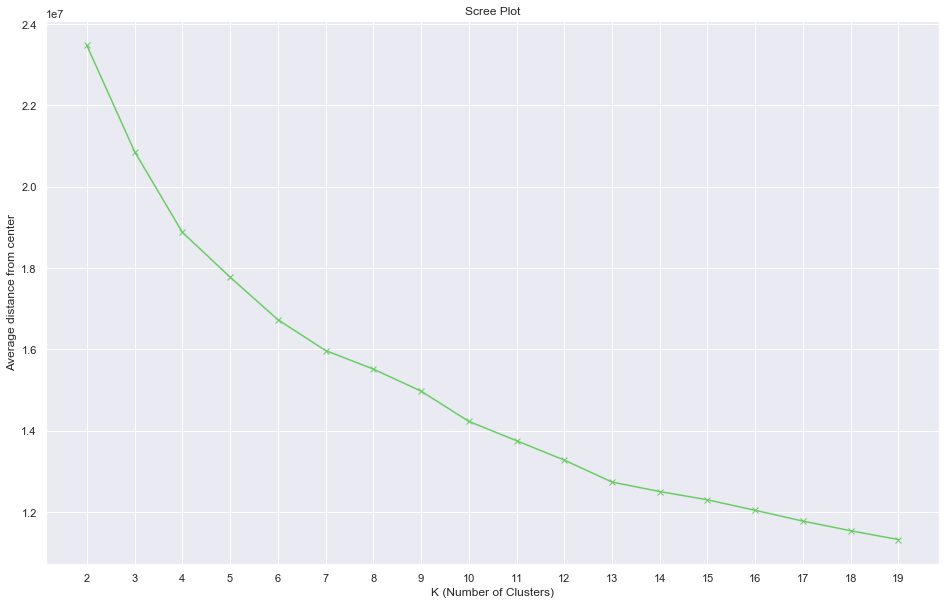

In [1554]:
# Plot relationship plot
fig, ax = plt.subplots(figsize=(16,10))    
ax = plt.plot([x[0] for x in scores], [x[1] for x in scores], marker='x', color='g')
plt.title("Scree Plot")
plt.xlabel("K (Number of Clusters)")
plt.ylabel("Average distance from center")
plt.xticks(list(range(2,20)));

In [1555]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans_final = KMeans(n_clusters=10).fit(X_pca_3)

In [1556]:
kmeans_final.cluster_centers_.shape

(10, 15)

### Discussion 3.1: Apply Clustering to General Population

The relationship plot showed a smooth curve without a drastic "elbow" demarcating where the clusters become less effective at reducing the average distance from the center.  Based on the plot, I've chosen to set the number of clusters to form at 10.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [1557]:
# Load in the customer demographics data.
customers = pd.read_csv('data/Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [1558]:
customers.shape

(191652, 85)

In [1559]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,0.0,0.0,1,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,0.0,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,8,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1,0.0,0.0,2,1,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


##### Data Cleaning

In [1560]:
df_cust = clean_data(customers, feat_info)

Copying dataframes
Converting missing/unknown values to NaN
Remove selected columns/rows
Re-encoding categorical features
Engineering mixed type features
Done


In [1561]:
df_cust.shape

(137972, 49)

##### Feature Transformation

In [1562]:
# We are only transforming the dataframe, not fitting it
df_cust_impute = imputer.transform(df_cust)

In [1572]:
# Apply feature scaling using the imputed data
df_cust_scaled = scaler.transform(df_cust_impute)

In [1573]:
# Create a new dataframe using the scaled features
df_cust_ss = pd.DataFrame(df_cust_scaled, columns=df_cust.columns)

In [1574]:
df_cust_ss.shape

(137972, 49)

##### Dimensionality Reduction

In [1575]:
# Reduce features to 15 components and transform scaled dataframe
X_pca_cust = pca_3.transform(df_cust_ss)

In [1576]:
# Construct a new dataframe with the reduced features
df_pca_cust = pd.DataFrame(X_pca_cust)
df_pca_cust.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-3.601686,-5.913071,-0.557638,1.337720,1.958562,1.127250,1.145718,-1.038710,-0.826988,0.061972,-0.911426,-0.056453,-0.108332,0.580131,-0.416090
1,-5.041810,0.951988,-0.314848,2.701236,0.710687,-0.209108,-0.035387,-0.158001,-0.304178,-1.462130,-0.337596,-1.444125,0.318705,0.371298,-0.298656
2,-2.371782,-3.936195,-0.382249,-2.290958,2.131481,0.969793,-0.280929,0.002597,0.125996,-0.452140,-0.665908,-0.449433,0.057987,-0.097892,-0.061028
3,1.170212,-0.936657,0.808477,-0.097496,1.262044,-0.871708,-0.352558,-0.083775,-0.606023,2.659664,1.363562,-0.975354,-0.075121,0.283245,0.617604
4,-2.345674,-3.146887,0.443046,2.423406,0.063093,-1.151882,-1.014307,1.357667,-1.000809,-1.594427,0.248349,-0.803406,0.178884,-1.096690,0.885938


In [1516]:
df_pca_cust.shape

(137972, 15)

##### KMeans Clustering

We will use the KMeans model instantiated in the previous section to predict customer data.

In [1577]:
# Predict using the KMeans model used in the previous section
kmeans_cust = kmeans_final.predict(X_pca_cust)

In [1583]:
# Check size of the labels
kmeans_cust.shape

(137972,)

In [1588]:
# Compare with size of KMeans
# Based on sklearn docs, "labels_" indicate the labels of each point
kmeans_final.labels_.shape

(776413,)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [1590]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Copy the labels to another variable
cust_labels = kmeans_cust.copy()
pop_label = kmeans_final.labels_.copy()

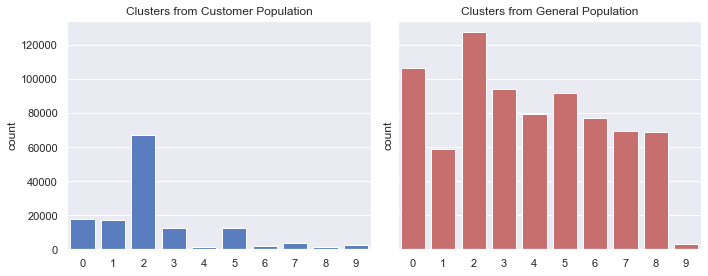

In [1604]:
# Plot both customer and general population clusters.
f, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
sns.countplot(cust_labels, color='b', ax=axes[0])
sns.countplot(pop_label, color='r', ax=axes[1])

# Add titles
axes[0].set_title('Clusters from Customer Population')
axes[1].set_title('Clusters from General Population')

# Helper to prevent overlapping labels
plt.tight_layout();

The scale between the two are quite different, so it's difficult to compare. Let's calculate the proportion of each cluster so it is more suitable for comparison.

In [1648]:
# Normalize values for comparison
cust_labels_norm = pd.Series(cust_labels).value_counts(normalize=True, sort=False).round(3) * 100
pop_label_norm = pd.Series(pop_label).value_counts(normalize=True, sort=False).round(3) * 100

# Calculate the diff between the customer cluster segmenets and general population
cust_pop_diff = cust_labels_norm - pop_label_norm

In [1660]:
# Merge all into a dataframe
cust_gen_df = pd.DataFrame([range(1,11), cust_labels_norm, pop_label_norm, cust_pop_diff]).T
cust_gen_df = cust_gen_df.rename({0:'cluster', 1:'customer', 2:'general', 3:'cust_pop_diff'}, axis=1)
cust_gen_df['cluster'] = cust_gen_df['cluster'].astype('int32')

In [1661]:
cust_gen_df

,cluster,customer,general,cust_pop_diff
0,1,12.7,13.7,-1.0
1,2,12.3,7.5,4.8
2,3,48.8,16.5,32.3
3,4,9.0,12.1,-3.1
4,5,1.0,10.2,-9.2
5,6,8.9,11.8,-2.9
6,7,1.5,9.9,-8.4
7,8,2.7,9.0,-6.3
8,9,1.0,8.9,-7.9
9,10,2.0,0.4,1.6


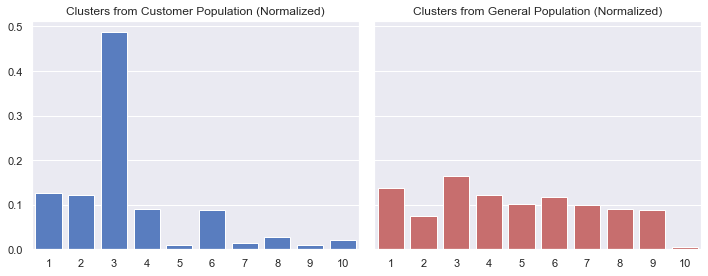

In [1606]:
# Plot both customer and general population clusters.

# Create x array
cust_index = [x+1 for x in cust_labels_norm.index.tolist()]
pop_index = [x+1 for x in pop_label_norm.index.tolist()]

# Plot barplots
f, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
sns.barplot(x=cust_index, y=cust_labels_norm, color='b', ax=axes[0])
sns.barplot(x=pop_index, y=pop_label_norm, color='r', ax=axes[1])

# Add titles
axes[0].set_title('Clusters from Customer Population (Normalized)')
axes[1].set_title('Clusters from General Population (Normalized)')

# Helper to prevent overlapping labels
plt.tight_layout();

In [1619]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
print_component(pca_3, 3)

Most weighted features for component 3 

ORTSGR_KLS9    0.276
EWDICHTE       0.272
wealth         0.237
ARBEIT         0.214
RELAT_AB       0.199
Name: 2, dtype: float64 

INNENSTADT       -0.236
KONSUMNAEHE      -0.216
ANREDE_KZ        -0.207
BALLRAUM         -0.192
FINANZ_ANLEGER   -0.180
Name: 2, dtype: float64


##### Component 3 Interpetations

Below are the mappings of the features from the data dictionary:

##### Most Positive Features:

1. ORTSGR_KLS9 - Size of community (1: <= 2,000 inhabitants, 9: > 700,000 inhabitants)
2. EWDICHTE - Density of households per square kilometer (1: less than 34 households per km^2, 6: more than 999 households per km^2)
3. wealth - wealth of family household (1: wealthy, 5: poorer)
4. ARBEIT - Share of unemployment in community (1: very low, 5: very high)
5. HH_EINKOMMEN_SCORE - Estimated household net income (1: highest income, 6: very low income)

##### Most Negative Features:

1. INNENSTADT - Distance to city center (downtown) (1: in city center, 8: more than 40 km to city center)
2. KONSUMNAEHE - Distance from building to point of sale (PoS) (1: building is located in a 125 x 125m grid cell (RA1), which is a consumption cell, 7: building is not located in a 10 x 10km range of a consumption cell)
3. ANREDE_KZ - Gender (1: Male, 2:Female)
4. BALLRAUM - Distance to nearest urban center (1: less than 10 km, 7: more than 100 km)
5. FINANZ_ANLEGER - Financial typology (1: very high, 5: very low); ANLEGER: investor

##### Interpretation

The third component grouped together population density as well as location of the household.  Positive features showed a population in urban setting with a lower socio-economic status.  Negative features captured a population that is also urban.  One outlier is financial typology which shows a high financial typology to an investor, which seems contrary to the characteristics of the other features.

In [1666]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
print_component(pca_3, 5)

Most weighted features for component 5 

OST_WEST_KZ            0.430
KBA13_ANZAHL_PKW       0.335
ANZ_HH_TITEL           0.221
ANZ_HAUSHALTE_AKTIV    0.201
FINANZ_VORSORGER       0.134
Name: 4, dtype: float64 

ARBEIT               -0.486
RELAT_AB             -0.317
GEBAEUDETYP_RASTER   -0.237
KONSUMNAEHE          -0.215
ONLINE_AFFINITAET    -0.135
Name: 4, dtype: float64


##### Component 5 Interpetations

Below are the mappings of the features from the data dictionary:

##### Most Positive Features:

1. OST_WEST_KZ - Building location via former East / West Germany (GDR / FRG) (O: East (GDR), W: West (FRG))
2. KBA13_ANZAHL_PKW - Number of cars in the PLZ8 region
3. ANZ_HH_TITEL - Number of professional academic title holders in building
4. ANZ_HAUSHALTE_AKTIV - Number of households in the building
5. FINANZ_VORSORGER - Financial typology; VORSORGER: be prepared (1: very high, 5: very low)

##### Most Negative Features:

1. ARBEIT - Share of unemployment in community (1: very low, 5: very high)
2. RELAT_AB - Share of unemployment relative to county in which community is contained (1: very low, 5: very high)
3. GEBAEUDETYP_RASTER - Ratio of residential to commercial activity (1: business cell, 5: residential cell)
4. KONSUMNAEHE - Distance from building to point of sale (PoS) (1: building is located in a 125 x 125m grid cell (RA1), which is a consumption cell, 7: building is not located in a 10 x 10km range of a consumption cell)
5. ONLINE_AFFINITAET - Online affinity (0: none, 5: highest)

##### Interpretation

The least represented cluster had high positive features for location in former West Germany, higher number of cars, higher number professional academic title holders and total households in the building, and low affinity for financial preparation.

The negative feature show a cluster with a low share unemployment, lives in a area with higher commercial activity and closer to a consumption cell and low online affinity.

### Discussion 3.3: Compare Customer Data to Demographics Data

Based on the analysis, we find that the segment that is over-represented in the customer population compared to the general population are __males in the lower socio-economic strata that reside in highly urban areas__ (cluster 3).  This cluster had a remarkably high proportion in the customer population (__48.8%__) compared to the general population (16.5%) with a difference of __32.3%__.  __This customer segment should be prioritized for the marketing campaign.__

In contrast, the population that is the least represented (and thus the least viable target for marketing) are those located in the West Germany living in a higher density environment close to businesses, and higher affinity with holding an academic title.  This cluster also is characterized by low unemployment rates and lower online affinity.  In general, __this segment portray an educated class living in an economically active area__.  This segment was the least represented in comparison with the general population, having an absolute difference of __-9.2%__ from the general population.  We recommend that this group should be of lowest priority for marketing.

### Appendix

#### References

Clustering
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
- https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler.transform
- https://stackoverflow.com/questions/28344660/how-to-identify-cluster-labels-in-kmeans-scikit-learn
- https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a
- Feature scaling vs transformation: https://knowledge.udacity.com/questions/172058
- Fitting customer data: https://knowledge.udacity.com/questions/118132

Components and Weights
- Extracting weights from components: https://knowledge.udacity.com/questions/117888
- https://knowledge.udacity.com/questions/178558
- https://knowledge.udacity.com/questions/152860
- https://knowledge.udacity.com/questions/125109
- https://knowledge.udacity.com/questions/180691
- https://online.stat.psu.edu/stat505/lesson/11/11.4

Pandas / NumPy / Python
- replace() vs map() https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html?highlight=replace#pandas.DataFrame.replace
- https://stackoverflow.com/questions/29700552/series-objects-are-mutable-and-cannot-be-hashed-error
- https://stackoverflow.com/questions/47136436/python-pandas-convert-value-counts-output-to-dataframe
- https://www.geeksforgeeks.org/python-converting-all-strings-in-list-to-integers/
- numpy.prod https://numpy.org/doc/stable/reference/generated/numpy.prod.html?highlight=numpy%20prod#numpy.prod

Plotting
- https://stackoverflow.com/questions/332289/how-do-you-change-the-size-of-figures-drawn-with-matplotlib
- https://seaborn.pydata.org/generated/seaborn.distplot.html